In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 遗传算法参数
POP_SIZE = 50       # 种群规模
GEN_MAX = 100       # 最大迭代次数
CROSS_RATE = 0.8    # 交叉概率
MUTATE_RATE = 0.1   # 变异概率
PATH_LENGTH = 30    # 路径长度（基因长度）

# 环境参数
GRID_SIZE = 200
OBSTACLE_PROB = 0.1  # 障碍物生成概率

# 初始化网格环境
class SearchEnv:
    def __init__(self):
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE))
        self.target_prob = np.zeros((GRID_SIZE, GRID_SIZE))
        self.generate_environment()
        
    def generate_environment(self):
        # 生成障碍物（1表示障碍物）
        self.grid = np.random.choice([0,1], size=(GRID_SIZE,GRID_SIZE), 
                                   p=[1-OBSTACLE_PROB, OBSTACLE_PROB])
        
        # 生成目标概率分布（障碍物区域概率为0）
        temp_prob = np.random.rand(GRID_SIZE, GRID_SIZE)
        mask = (self.grid == 0)  # 可通行区域
        self.target_prob = np.where(mask, temp_prob, 0)
        self.target_prob /= self.target_prob.sum()  # 归一化概率分布

# 路径个体类
class PathIndividual:
    def __init__(self, env):
        self.path = []
        self.fitness = 0
        self.generate_path(env)
        
    def generate_path(self, env):
        # 生成可行路径（避开障碍物）
        while len(self.path) < PATH_LENGTH:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if env.grid[x][y] == 0 and (x,y) not in self.path:
                self.path.append((x,y))
                
    def calculate_fitness(self, env):
        # 计算累积发现概率
        total_prob = 0
        for (x,y) in self.path:
            if env.grid[x][y] == 1:  # 撞到障碍物
                self.fitness = 0
                return
            total_prob += env.target_prob[x][y]
        self.fitness = total_prob

# 遗传算法主体
class GeneticSearch:
    def __init__(self, env):
        self.env = env
        self.population = [PathIndividual(env) for _ in range(POP_SIZE)]
        
    def evolve(self):
        for generation in range(GEN_MAX):
            # 计算适应度
            for ind in self.population:
                ind.calculate_fitness(self.env)
            
            # 选择
            fitness = [ind.fitness for ind in self.population]
            selected = self.roulette_selection(fitness)
            
            # 交叉
            children = []
            for i in range(0, POP_SIZE, 2):
                parent1 = self.population[selected[i]]
                parent2 = self.population[selected[i+1]]
                child1, child2 = self.crossover(parent1, parent2)
                children.extend([child1, child2])
            
            # 变异
            self.population = [self.mutate(child) for child in children]
            
            # 记录最佳个体
            best = max(self.population, key=lambda x: x.fitness)
            print(f"Gen {generation}: Best Fitness = {best.fitness:.4f}")
            
        return best
    
    def roulette_selection(self, fitness):
        # 轮盘赌选择
        sum_fit = sum(fitness)
        probs = [f/sum_fit for f in fitness]
        cum_probs = np.cumsum(probs)
        selected = []
        for _ in range(POP_SIZE):
            r = random.random()
            for i, cp in enumerate(cum_probs):
                if r <= cp:
                    selected.append(i)
                    break
        return selected
    
    def crossover(self, parent1, parent2):
        # 单点交叉
        pt = random.randint(1, PATH_LENGTH-2)
        child1 = PathIndividual(self.env)
        child2 = PathIndividual(self.env)
        child1.path = parent1.path[:pt] + parent2.path[pt:]
        child2.path = parent2.path[:pt] + parent1.path[pt:]
        return child1, child2
    
    def mutate(self, individual):
        # 随机变异一个节点
        if random.random() < MUTATE_RATE:
            idx = random.randint(0, PATH_LENGTH-1)
            new_x = random.randint(0, GRID_SIZE-1)
            new_y = random.randint(0, GRID_SIZE-1)
            if self.env.grid[new_x][new_y] == 0:
                individual.path[idx] = (new_x, new_y)
        return individual

# 可视化函数
def visualize(env, best_path):
    plt.figure(figsize=(12,6))
    
    # 环境可视化
    plt.subplot(121)
    cmap = ListedColormap(['white', 'black', 'red'])
    env_display = np.copy(env.grid)
    for (x,y) in best_path.path:
        env_display[x][y] = 2
    plt.imshow(env_display.T, cmap=cmap)
    plt.title("Search Environment with Path")
    
    # 概率分布可视化
    plt.subplot(122)
    plt.imshow(env.target_prob.T, cmap='hot', interpolation='nearest')
    plt.title("Target Probability Distribution")
    plt.show()

# 主程序
if __name__ == "__main__":
    # 初始化环境
    env = SearchEnv()
    
    # 运行遗传算法
    ga = GeneticSearch(env)
    best_path = ga.evolve()
    
    # 结果可视化
    visualize(env, best_path)

Generating target trajectories...


100%|██████████| 200/200 [00:00<00:00, 213.07it/s]


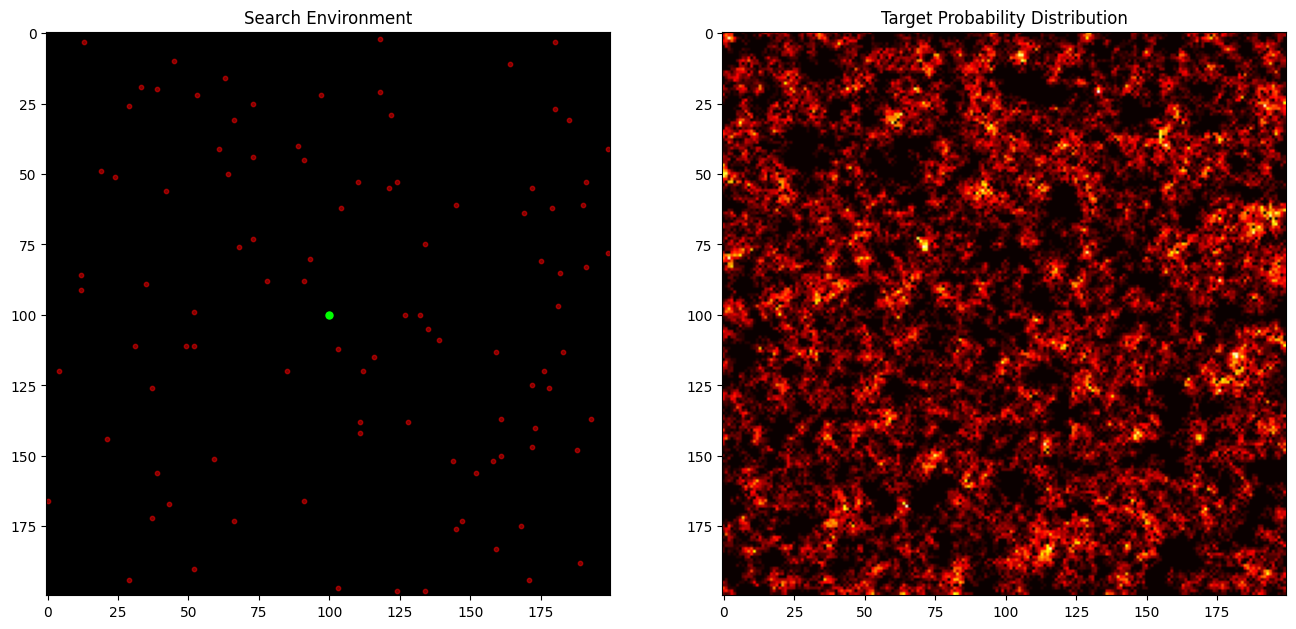

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import random

# 环境参数
GRID_SIZE = 200
OBSTACLE_PROB = 0.1
NUM_TARGET_TRAJ = 1000  # 蒙特卡洛轨迹数量
TARGET_STEPS = 100      # 目标移动步数

# 遗传算法参数
POP_SIZE = 100
GEN_MAX = 200
CROSS_RATE = 0.8
MUTATE_RATE = 0.2
PATH_LENGTH = 50        # 搜索路径长度

# 初始化环境
class SearchEnvironment:
    def __init__(self):
        self.grid, self.target_prob = self.generate_environment()
        self.start_pos = (GRID_SIZE//2, GRID_SIZE//2)  # 搜索起点
        
    def generate_environment(self):
        # 生成障碍物网格 (1为障碍物)
        grid = np.random.choice([0, 1], size=(GRID_SIZE, GRID_SIZE), 
                               p=[1-OBSTACLE_PROB, OBSTACLE_PROB])
        return grid, np.zeros_like(grid, dtype=float)

# 蒙特卡洛目标轨迹生成
class MonteCarloTarget:
    def __init__(self, env):
        self.env = env
        self.trajectories = []
        
    def generate_trajectories(self):
        print("Generating target trajectories...")
        for _ in tqdm(range(NUM_TARGET_TRAJ)):
            traj = [self.random_start()]
            for _ in range(TARGET_STEPS):
                next_pos = self.random_move(traj[-1])
                traj.append(next_pos)
            self.trajectories.append(traj)
        self.calculate_probability()
    
    def random_start(self):
        # 在非障碍区域随机选择起点
        while True:
            x, y = np.random.randint(0, GRID_SIZE, 2)
            if self.env.grid[x, y] == 0:
                return (x, y)
    
    def random_move(self, current_pos):
        # 带障碍检测的随机移动
        x, y = current_pos
        for _ in range(10):  # 最大尝试次数
            dx, dy = np.random.choice([-1, 0, 1], 2)
            new_x = np.clip(x + dx, 0, GRID_SIZE-1)
            new_y = np.clip(y + dy, 0, GRID_SIZE-1)
            if self.env.grid[new_x, new_y] == 0:
                return (new_x, new_y)
        return current_pos  # 无法移动时保持原位
    
    def calculate_probability(self):
        # 计算目标存在概率分布
        prob_grid = np.zeros((GRID_SIZE, GRID_SIZE))
        for traj in self.trajectories:
            for (x, y) in traj:
                prob_grid[x, y] += 1
        prob_grid = prob_grid / (NUM_TARGET_TRAJ * TARGET_STEPS)
        self.env.target_prob = np.where(self.env.grid==1, 0, prob_grid)  # 障碍物区域概率为0

# 遗传算法路径规划
class GeneticPathPlanner:
    def __init__(self, env):
        self.env = env
        self.population = []
        self.best_path = None
        
    class Individual:
        def __init__(self, path, fitness=0):
            self.path = path
            self.fitness = fitness
            
    def initialize_population(self):
        # 生成初始种群（确保路径连续）
        for _ in range(POP_SIZE):
            path = [self.env.start_pos]
            current_pos = self.env.start_pos
            for _ in range(PATH_LENGTH-1):
                next_pos = self.get_adjacent_pos(current_pos)
                path.append(next_pos)
                current_pos = next_pos
            self.population.append(self.Individual(path))
    
    def get_adjacent_pos(self, pos):
        # 获取可达的相邻位置
        x, y = pos
        candidates = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                new_x = x + dx
                new_y = y + dy
                if 0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE:
                    if self.env.grid[new_x, new_y] == 0:
                        candidates.append((new_x, new_y))
        return random.choice(candidates) if candidates else pos
    
    def evaluate_fitness(self, individual):
        # 计算路径累积概率（考虑路径连续性）
        total_prob = 0
        penalty = 0
        visited = set()
        for idx, (x, y) in enumerate(individual.path):
            if idx > 0:
                # 检查移动是否连续
                prev_x, prev_y = individual.path[idx-1]
                if abs(x - prev_x) > 1 or abs(y - prev_y) > 1:
                    penalty += 0.5
            if (x, y) in visited:  # 重复访问惩罚
                penalty += 0.2
            else:
                visited.add((x, y))
                total_prob += self.env.target_prob[x, y]
        individual.fitness = total_prob - penalty
    
    def selection(self):
        # 锦标赛选择
        selected = []
        for _ in range(POP_SIZE):
            candidates = random.sample(self.population, 3)
            winner = max(candidates, key=lambda x: x.fitness)
            selected.append(winner)
        return selected
    
    def crossover(self, parent1, parent2):
        # 两点交叉
        crossover_points = sorted(random.sample(range(1, PATH_LENGTH), 2))
        child1 = parent1.path[:crossover_points[0]] + parent2.path[crossover_points[0]:crossover_points[1]] + parent1.path[crossover_points[1]:]
        child2 = parent2.path[:crossover_points[0]] + parent1.path[crossover_points[0]:crossover_points[1]] + parent2.path[crossover_points[1]:]
        return self.Individual(child1), self.Individual(child2)
    
    def mutate(self, individual):
        # 自适应变异
        mutated_path = individual.path.copy()
        for i in range(1, PATH_LENGTH-1):
            if random.random() < MUTATE_RATE:
                # 尝试向高概率区域移动
                x, y = mutated_path[i]
                neighbors = [(x+dx, y+dy) for dx in [-1,0,1] for dy in [-1,0,1]
                            if 0<=x+dx<GRID_SIZE and 0<=y+dy<GRID_SIZE
                            and self.env.grid[x+dx][y+dy]==0]
                if neighbors:
                    best_neighbor = max(neighbors, key=lambda pos: self.env.target_prob[pos[0], pos[1]])
                    mutated_path[i] = best_neighbor
        return self.Individual(mutated_path)
    
    def evolve(self):
        self.initialize_population()
        best_fitness = -np.inf
        
        for gen in tqdm(range(GEN_MAX)):
            # 评估适应度
            for ind in self.population:
                self.evaluate_fitness(ind)
            
            # 精英保留
            sorted_pop = sorted(self.population, key=lambda x: -x.fitness)
            elites = sorted_pop[:2]
            
            # 选择
            selected = self.selection()
            
            # 交叉与变异
            children = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[i+1]
                child1, child2 = self.crossover(parent1, parent2)
                children.extend([self.mutate(child1), self.mutate(child2)])
            
            # 生成新一代
            self.population = elites + children[:POP_SIZE-2]
            
            # 记录最佳路径
            current_best = max(self.population, key=lambda x: x.fitness)
            if current_best.fitness > best_fitness:
                best_fitness = current_best.fitness
                self.best_path = current_best.path

# 可视化与动画
def visualize_system(env, target_traj, search_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # 环境可视化
    ax1.set_title("Search Environment")
    env_display = np.zeros((GRID_SIZE, GRID_SIZE, 3))
    env_display[env.grid==1] = [0, 0, 0]  # 障碍物黑色
    ax1.imshow(env_display)
    
    # 目标轨迹可视化
    line, = ax1.plot([], [], 'r-', lw=1, alpha=0.3)
    scatter = ax1.scatter([], [], c='r', s=10, alpha=0.5)
    
    # 概率分布可视化
    prob_display = ax2.imshow(env.target_prob.T, cmap='hot', animated=True)
    ax2.set_title("Target Probability Distribution")
    
    # 搜索路径初始化
    search_line, = ax1.plot([], [], 'g-', lw=2)
    search_points = ax1.scatter([], [], c='lime', s=50, edgecolor='black')
    
    def update(frame):
        # 更新目标轨迹
        if frame < TARGET_STEPS:
            x = [traj[frame][1] for traj in target_traj[:100]]
            y = [traj[frame][0] for traj in target_traj[:100]]
            scatter.set_offsets(np.c_[x, y])
        
        # 更新搜索路径
        if frame < len(search_path):
            path_x = [p[1] for p in search_path[:frame+1]]
            path_y = [p[0] for p in search_path[:frame+1]]
            search_line.set_data(path_x, path_y)
            search_points.set_offsets(np.c_[path_x[-1:], path_y[-1:]])
        
        return scatter, search_line, search_points
    
    ani = FuncAnimation(fig, update, frames=max(TARGET_STEPS, PATH_LENGTH),
                        interval=50, blit=True)
    plt.show()

# 主程序
if __name__ == "__main__":
    # 初始化环境
    env = SearchEnvironment()
    
    # 蒙特卡洛目标轨迹生成
    mc = MonteCarloTarget(env)
    mc.generate_trajectories()
    
    # 遗传算法路径规划
    planner = GeneticPathPlanner(env)
    planner.evolve()
    
    # 可视化
    visualize_system(env, mc.trajectories[:100], planner.best_path)

Generating target trajectories...


100%|██████████| 200/200 [00:15<00:00, 12.82it/s]


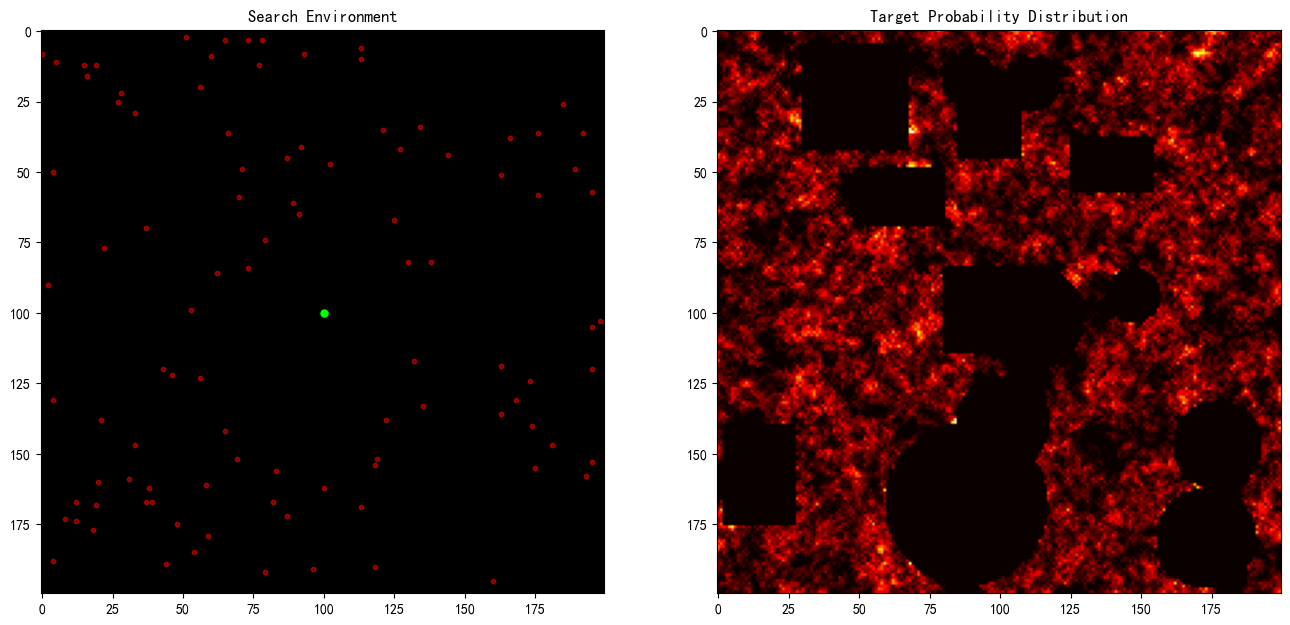

In [ ]:
#经验分布仿真（实验中）
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import numpy as np

# 环境参数
GRID_SIZE = 200
OBSTACLE_NUM = 15       # 非线性障碍物数量
NUM_TARGET_TRAJ = 1000  
TARGET_STEPS = 100      

# 遗传算法参数
POP_SIZE = 100
GEN_MAX = 200
CROSS_RATE = 0.8
MUTATE_RATE = 0.2
PATH_LENGTH = 50        

# 初始化环境（PyTorch实现）
class SearchEnvironment(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.grid, self.target_prob = self.generate_environment()
        self.start_pos = torch.tensor([GRID_SIZE//2, GRID_SIZE//2])
        
    def generate_environment(self):
        # 生成非线性障碍物（连续区域）
        grid = torch.zeros((GRID_SIZE, GRID_SIZE), dtype=torch.float32)
        
        # 生成随机形状障碍物
        for _ in range(OBSTACLE_NUM):
            # 随机选择障碍物类型：圆形或矩形
            if torch.rand(1) < 0.5:
                # 圆形障碍物
                center = torch.randint(0, GRID_SIZE, (2,))
                radius = torch.randint(10, 30, (1,))
                y, x = torch.meshgrid(torch.arange(GRID_SIZE), torch.arange(GRID_SIZE))
                dist = (x - center[0])**2 + (y - center[1])**2
                grid[dist < radius**2] = 1.0
            else:
                # 矩形障碍物
                w, h = torch.randint(20, 40, (2,))
                x0 = torch.randint(0, GRID_SIZE-w, (1,))
                y0 = torch.randint(0, GRID_SIZE-h, (1,))
                grid[x0:x0+w, y0:y0+h] = 1.0
        
        # 生成目标概率分布
        target_prob = torch.rand((GRID_SIZE, GRID_SIZE))
        target_prob[grid.bool()] = 0.0  # 障碍物区域概率清零
        target_prob /= target_prob.sum()
        
        return grid, target_prob

# 蒙特卡洛目标轨迹生成（PyTorch加速）
class MonteCarloTarget(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.trajectories = []
        
    def generate_trajectories(self):
        print("Generating target trajectories...")
        # 批量生成轨迹（GPU加速）
        batch_size = 200
        for _ in tqdm(range(NUM_TARGET_TRAJ // batch_size)):
            traj_batch = self.generate_batch_trajectories(batch_size)
            self.trajectories.extend(traj_batch)
        self.calculate_probability()
        return self.trajectories
    
    def generate_batch_trajectories(self, batch_size):
        # 批量生成轨迹（优化GPU利用率）
        current_pos = self.random_start_batch(batch_size).float()
        traj = [current_pos]
        
        for _ in range(TARGET_STEPS):
            move = torch.randint(-1, 2, (batch_size, 2), dtype=torch.float32)
            new_pos = torch.clamp(current_pos + move, 0, GRID_SIZE-1)
            
            # 障碍物检测
            valid_mask = self.env.grid[new_pos[:,0].long(), new_pos[:,1].long()] == 0
            current_pos = torch.where(valid_mask.unsqueeze(1), new_pos, current_pos)
            traj.append(current_pos.clone())
        
        return [t.cpu().numpy() for t in torch.stack(traj).permute(1,0,2)]
    
    def random_start_batch(self, batch_size):
        # 批量随机起点生成
        starts = []
        while len(starts) < batch_size:
            candidates = torch.randint(0, GRID_SIZE, (batch_size*2, 2))
            valid = self.env.grid[candidates[:,0], candidates[:,1]] == 0
            starts.extend(candidates[valid][:batch_size-len(starts)])
        return torch.stack(starts[:batch_size])
    
    def calculate_probability(self):
        # 合并轨迹点并转换为浮点张量
        all_points = torch.cat([torch.tensor(traj, dtype=torch.float32) 
                            for traj in self.trajectories], dim=0)
        
        # 确保坐标在有效范围内 [0, GRID_SIZE-1]
        all_points = torch.clamp(all_points, 0, GRID_SIZE-1 - 1e-6)  # 避免浮点误差
        
        # 转换为网格索引（整数坐标）
        x_idx = (all_points[:, 0]).long()
        y_idx = (all_points[:, 1]).long()
        
        # 确保索引不越界
        x_idx = torch.clamp((all_points[:, 0] + 0.5).long(), 0, GRID_SIZE-1)
        y_idx = torch.clamp((all_points[:, 1] + 0.5).long(), 0, GRID_SIZE-1)
        
        # 计算一维索引
        flat_indices = x_idx * GRID_SIZE + y_idx
        
        # 计算频次（限制最大索引）
        max_index = GRID_SIZE * GRID_SIZE - 1
        flat_indices = torch.clamp(flat_indices, 0, max_index)
        hist = torch.bincount(flat_indices, minlength=GRID_SIZE**2)
        
        # 重塑为二维概率矩阵
        hist = hist[:GRID_SIZE**2].view(GRID_SIZE, GRID_SIZE).float()
        
        # 计算概率分布
        self.env.target_prob = hist / (NUM_TARGET_TRAJ * TARGET_STEPS)
        self.env.target_prob[self.env.grid.bool()] = 0.0

# 遗传算法路径规划（PyTorch实现）
class GeneticPathPlanner(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.population = None
        self.best_path = None

    def get_valid_neighbors(self, pos):
        # 输入pos形状应为 (2,)
        x, y = pos
        deltas = torch.tensor([[dx, dy] for dx in [-1,0,1] for dy in [-1,0,1] if (dx, dy) != (0,0)])
        neighbors = pos + deltas  # 形状自动广播为 (8, 2)
        
        # 筛选有效位置
        valid_mask = (neighbors >= 0) & (neighbors < GRID_SIZE)
        valid_mask = valid_mask.all(dim=1)
        neighbors = neighbors[valid_mask]
        
        # 进一步筛选非障碍物
        grid_valid = self.env.grid[neighbors[:,0].long(), neighbors[:,1].long()] == 0
        return neighbors[grid_valid]  # 形状为 (N, 2)
        
    def initialize_population(self):
        # 使用张量存储种群（POP_SIZE, PATH_LENGTH, 2）
        population = []
        for _ in range(POP_SIZE):
            path = self.generate_single_path()
            population.append(path)
        self.population = torch.stack(population)
        
   
    def generate_single_path(self):
        # 生成连续且唯一性路径
        path = [self.env.start_pos.clone().float()]
        current_pos = self.env.start_pos.clone()
        visited = set()
        
        for _ in range(PATH_LENGTH-1):
            neighbors = self.get_valid_neighbors(current_pos)
            if len(neighbors) == 0:
                next_pos = current_pos.clone()
            else:
                # 优先选择未访问的邻域
                unvisited = [pos for pos in neighbors if tuple(pos.tolist()) not in visited]
                if unvisited:
                    idx = torch.randint(len(unvisited), (1,)).item()
                    next_pos = unvisited[idx]
                else:
                    idx = torch.randint(len(neighbors), (1,)).item()
                    next_pos = neighbors[idx]
            
            path.append(next_pos)
            visited.add(tuple(next_pos.tolist()))
            current_pos = next_pos.clone()
        
        return torch.stack(path)
    
    def evaluate_fitness(self):
        # 批量计算适应度（GPU加速）
        batch_points = self.population.view(-1, 2).long()
        probs = self.env.target_prob[batch_points[:,0], batch_points[:,1]]
        probs = probs.view(POP_SIZE, PATH_LENGTH)
        
        # 连续性惩罚
        diff = torch.abs(self.population[:,1:] - self.population[:,:-1])
        continuity_penalty = (diff.sum(dim=2) > 1).float().sum(dim=1) * 0.5
        
        # 重复访问惩罚（修正长度问题）
        max_unique = PATH_LENGTH  # 路径固定长度，最大唯一点数为PATH_LENGTH
        unique_counts_list = []
        for p in self.population:
            unique, counts = torch.unique(p, dim=0, return_counts=True)
            padded_counts = torch.nn.functional.pad(counts, (0, max_unique - len(counts)), value=0)  # 填充至固定长度
            unique_counts_list.append(padded_counts)
    
        unique_counts = torch.stack(unique_counts_list)
        repeat_penalty = (unique_counts > 1).sum(dim=1) * 0.2
        
        return probs.sum(dim=1) - continuity_penalty - repeat_penalty
    
    def evolve(self):
        self.initialize_population()
        device = self.env.grid.device
        
        for _ in tqdm(range(GEN_MAX)):
            # 评估适应度
            fitness = self.evaluate_fitness()
            
            # 选择（锦标赛选择）
            selected_idx = torch.zeros(POP_SIZE, dtype=torch.long, device=device)
            for i in range(POP_SIZE):
                candidates = torch.randint(POP_SIZE, (3,))
                selected_idx[i] = candidates[fitness[candidates].argmax()]
            self.population = self.population[selected_idx]
            
            # 交叉（两点交叉）
            crossover_mask = torch.rand(POP_SIZE, device=device) < CROSS_RATE
            crossover_points = torch.randint(1, PATH_LENGTH-1, (2, POP_SIZE))
            for i in range(0, POP_SIZE, 2):
                if crossover_mask[i] and i+1 < POP_SIZE:
                    start, end = crossover_points[:,i].sort().values
                    temp = self.population[i, start:end].clone()
                    self.population[i, start:end] = self.population[i+1, start:end]
                    self.population[i+1, start:end] = temp
            
            # 变异（导向型变异）
            mutate_mask = torch.rand_like(self.population[:,:,0]) < MUTATE_RATE
            for i in range(POP_SIZE):
                for j in range(1, PATH_LENGTH-1):  # 避开起点
                    if mutate_mask[i,j]:
                        neighbors = self.get_valid_neighbors(self.population[i,j-1])
                        if len(neighbors) > 0:
                            # 选择概率最高的邻域
                            neighbors_long = neighbors.long()  # 转换为LongTensor
                            neighbor_probs = self.env.target_prob[neighbors_long[:,0], neighbors_long[:,1]]
                            self.population[i,j] = neighbors[neighbor_probs.argmax()]
            
            # 更新最佳路径
            best_idx = fitness.argmax()
            self.best_path = self.population[best_idx].cpu().numpy()

    # 可视化函数
    def visualize_system(env, search_path):
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # 障碍物可视化（保持不变）
        ax.set_title("Search Path & Obstacles")
        env_display = torch.zeros((GRID_SIZE, GRID_SIZE, 3), dtype=torch.float32)
        env_display[env.grid.bool()] = torch.tensor([0.2, 0.2, 0.2], dtype=torch.float32)
        ax.imshow(env_display.numpy(), origin='lower')  # 关键修改：设置origin='lower'
        
        # 初始化元素
        path_line, = ax.plot([], [], 'go-', lw=2, markersize=8, markerfacecolor='yellow', markeredgecolor='black')
        current_point = ax.scatter([], [], c='red', s=100, edgecolor='black', zorder=5)
        
        # 增强可视化（保持不变）
        ax.grid(which='both', color='lightgray', linestyle='--', linewidth=0.5)
        ax.set_xticks(np.arange(0, GRID_SIZE, 20))
        ax.set_yticks(np.arange(0, GRID_SIZE, 20))
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")

        def update(frame):
            if frame < len(search_path):
                # 正确提取坐标点（交换行列顺序）
                x_coords = search_path[:frame+1, 1].tolist()  # 列坐标 -> x轴
                y_coords = search_path[:frame+1, 0].tolist()  # 行坐标 -> y轴
                
                # 更新路径线
                path_line.set_data(x_coords, y_coords)
                
                # 更新当前点
                if len(x_coords) > 0:
                    current_point.set_offsets(np.c_[x_coords[-1], y_coords[-1]])
            
            return path_line, current_point

        # 创建动画（帧数需匹配路径长度）
        ani = FuncAnimation(fig, update, 
                        frames=len(search_path),  # 直接使用路径长度
                        interval=100, 
                        blit=True,
                        repeat=False)
        
        ax.legend([path_line, current_point], 
                ['Search Path', 'Current Position'],
                loc='upper right')
        
        plt.tight_layout()
        plt.show()

        # 创建动画
        ani = FuncAnimation(fig, update, 
                        frames=len(search_path)+5,  # +5保持最后帧的显示
                        interval=100, 
                        blit=True,
                        repeat=False)
        
        # 添加图例
        ax.legend([path_line, current_point], 
                ['Search Path', 'Current Position'],
                loc='upper right')
        
        plt.tight_layout()
        plt.show()

# 主程序
if __name__ == "__main__":
    # 初始化环境（GPU加速）
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = SearchEnvironment().to(device)
    
    # 蒙特卡洛目标轨迹生成
    mc = MonteCarloTarget(env).to(device)
    trajectories = mc.generate_trajectories()
    
    # 遗传算法路径规划
    planner = GeneticPathPlanner(env).to(device)
    planner.evolve()
    
    # 可视化
    visualize_system(env.cpu(), trajectories[1:100], planner.best_path)

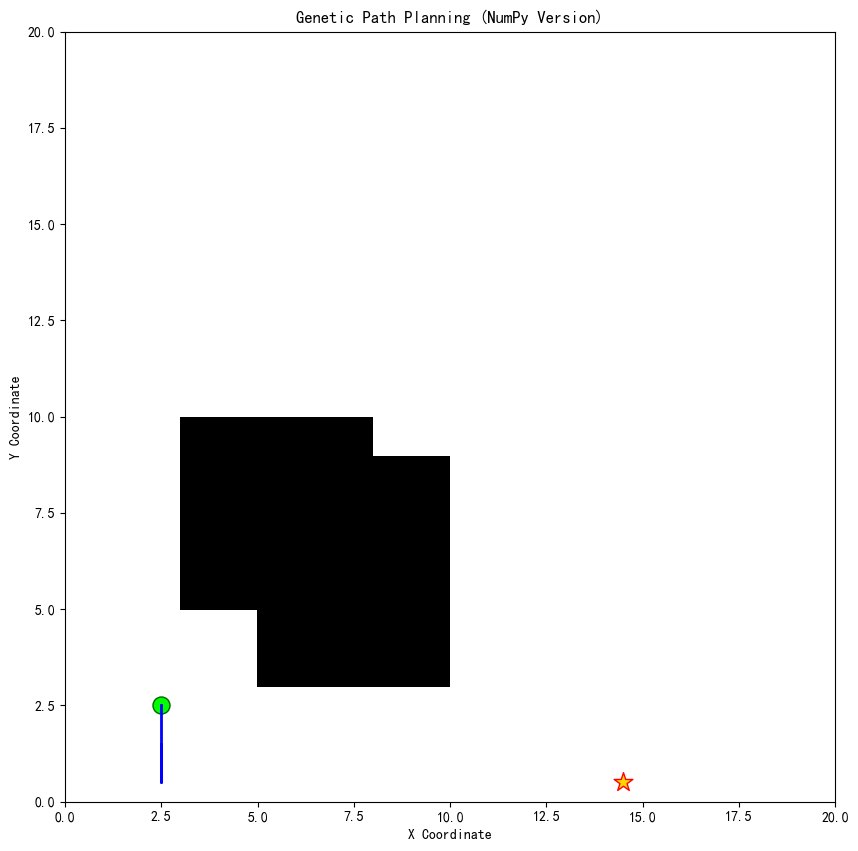

In [ ]:
#均匀分布 torch
import torch
import matplotlib.pyplot as plt

# 参数设置
GRID_SIZE = 20
POP_SIZE = 50
GEN_MAX = 200
PATH_LENGTH = 200
OBSTACLE_NUM = 4
START_POS = torch.tensor([12, 10])

TARGET_NUM = 2  # 随机生成的目标点数量

class SearchEnvironment:
    def __init__(self):
        # 生成随机障碍物
        self.grid = torch.zeros((GRID_SIZE, GRID_SIZE))
        for _ in range(OBSTACLE_NUM):
            x, y = torch.randint(0, GRID_SIZE, (2,))
            radius = torch.randint(0, 3, (1,))
            self.grid[max(0,x-radius):min(GRID_SIZE,x+radius), 
                     max(0,y-radius):min(GRID_SIZE,y+radius)] = 1
            
        # 均匀目标概率分布
        self.target_prob = torch.ones((GRID_SIZE, GRID_SIZE))
        self.target_prob[self.grid.bool()] = 0

class GeneticPathPlanner:
    def __init__(self, env):
        self.env = env
        self.population = []
        
    def get_neighbors(self, pos):
        """获取有效邻域坐标"""
        deltas = torch.tensor([[-1,0], [1,0], [0,-1], [0,1], 
                             [-1,-1], [-1,1], [1,-1], [1,1]])
        neighbors = pos + deltas
        valid = (neighbors >= 0) & (neighbors < GRID_SIZE)
        return neighbors[valid.all(dim=1) & (self.env.grid[neighbors[:,0], neighbors[:,1]] == 0)]

    def generate_path(self):
        """修改点3：路径生成增加有效性验证"""
        for _ in range(100):  # 最大尝试次数
            path = [START_POS.clone()]
            current = START_POS.clone()
            valid = True
            
            for _ in range(PATH_LENGTH-1):
                neighbors = self.get_neighbors(current)
                if len(neighbors) == 0:
                    valid = False
                    break
                current = neighbors[torch.randint(len(neighbors), (1,))].squeeze()
                path.append(current.clone())
            
            if valid:
                return torch.stack(path)
        return torch.stack([START_POS]*PATH_LENGTH)  # 保底返回初始位置

    def evaluate(self, path):
        """修改点2：强化障碍物惩罚机制"""
        # 检查路径有效性（是否经过障碍物）
        path_valid = (self.env.grid[path[:,0].long(), path[:,1].long()] == 0).all()
        
        # 计算路径平滑度惩罚（防止锯齿路径）
        direction_changes = torch.sum(torch.abs(path[1:] - path[:-1]).sum(dim=1) > 1.5)
        
        # 复合适应度 = 目标概率总和 - 方向变化惩罚 - 无效路径重罚
        return (self.env.target_prob[path[:,0].long(), path[:,1].long()].sum() 
                - direction_changes * 0.2 
                - (1 - path_valid.float()) * 100)  # 无效路径重罚

    def evolve(self):
        # 初始化种群
        self.population = [self.generate_path() for _ in range(POP_SIZE)]
        best_fitness = -float('inf')
        best_individual = None

        for _ in range(GEN_MAX):
            # 评估适应度


            
            fitness = torch.tensor([self.evaluate(p) for p in self.population])
                
            # 记录历史最优
            current_best_idx = fitness.argmax()
            if fitness[current_best_idx] > best_fitness:
                best_fitness = fitness[current_best_idx]
                best_individual = self.population[current_best_idx].clone()
            self.population[0] = best_individual

            # 选择 (锦标赛选择)
            selected = [self.population[torch.where(fitness == fitness.max())[0][0]]]
            for _ in range(POP_SIZE-1):
                candidates = torch.randint(POP_SIZE, (3,))
                selected.append(self.population[candidates[fitness[candidates].argmax()]])
            
            # 交叉 (单点交叉)
            new_pop = []
            for i in range(0, POP_SIZE, 2):
                cross_point = torch.randint(1, PATH_LENGTH, (1,))
                child1 = torch.cat([selected[i][:cross_point], selected[i+1][cross_point:]])
                child2 = torch.cat([selected[i+1][:cross_point], selected[i][cross_point:]])
                new_pop.extend([child1, child2])
            
            # 变异 (随机点重置)
            for i in range(POP_SIZE):
                if torch.rand(1) < 0.1:
                    mut_point = torch.randint(1, PATH_LENGTH, (1,))
                    prev_pos = self.population[i][mut_point-1].long()
                    neighbors = self.get_neighbors(prev_pos)
                    if len(neighbors) > 0:
                        # 选择目标概率最高的邻域
                        neighbor_probs = self.env.target_prob[neighbors[:,0], neighbors[:,1]]
                        self.population[i][mut_point] = neighbors[neighbor_probs.argmax()]
            self.population = new_pop
            self.population[0] = best_individual  # 确保精英保留
        return best_individual

# 运行仿真
env = SearchEnvironment()
planner = GeneticPathPlanner(env)
best_path = planner.evolve()

# 可视化
plt.figure(figsize=(10,10))
plt.imshow(env.grid, cmap='Greys', origin='lower')
plt.plot(best_path[:,1].numpy(), best_path[:,0], 'r-', lw=2)
plt.scatter(START_POS[1], START_POS[0], c='g', s=100)
plt.show()

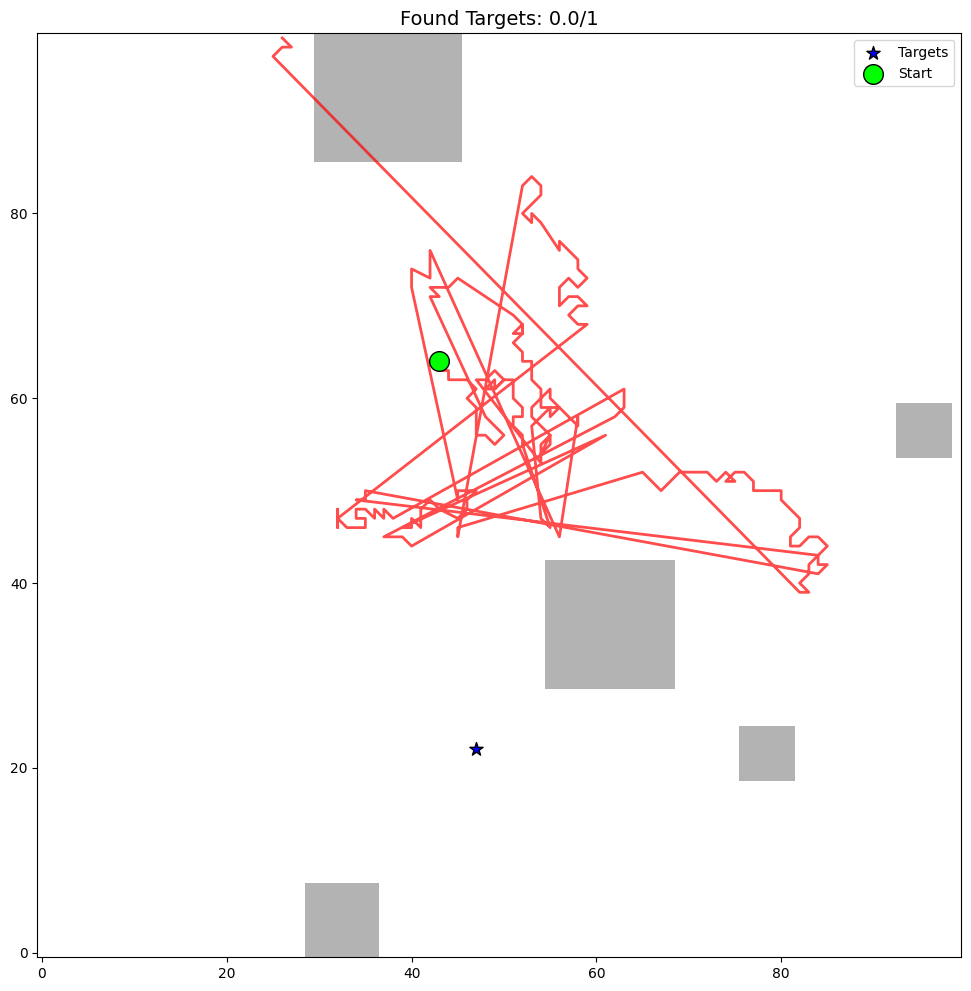

In [63]:
import torch
import matplotlib.pyplot as plt

# 参数设置
GRID_SIZE = 100
POP_SIZE = 100
GEN_MAX = 300
PATH_LENGTH = 200
OBSTACLE_NUM = 5
START_POS = torch.tensor([64, 43])

TARGET_NUM = 1  # 随机生成的目标点数量

class SearchEnvironment:
    def __init__(self):
        self.grid = torch.zeros((GRID_SIZE, GRID_SIZE))
        start_x, start_y = START_POS.tolist()  # 获取初始坐标
        
        # 生成不覆盖起始点的障碍物
        obstacles_created = 0
        max_attempts = 100  # 每个障碍物的最大尝试次数
        
        while obstacles_created < OBSTACLE_NUM and max_attempts > 0:
            x = torch.randint(0, GRID_SIZE, (1,)).item()
            y = torch.randint(0, GRID_SIZE, (1,)).item()
            radius = torch.randint(2, 10, (1,)).item()
            
            # 计算障碍物边界
            x_min = max(0, x - radius)
            x_max = min(GRID_SIZE, x + radius)
            y_min = max(0, y - radius)
            y_max = min(GRID_SIZE, y + radius)
            
            # 检查是否覆盖起始点
            start_in_obstacle = (
                (x_min <= start_x < x_max) and 
                (y_min <= start_y < y_max)
            )
            
            # 检查是否与已有障碍物重叠
            overlap = self.grid[x_min:x_max, y_min:y_max].any()
            
            if not start_in_obstacle and not overlap:
                self.grid[x_min:x_max, y_min:y_max] = 1
                obstacles_created += 1
                max_attempts = 100  # 重置尝试次数
            else:
                max_attempts -= 1
            
        # 修改点1：生成0-1分布目标概率
        self.target_prob = torch.zeros((GRID_SIZE, GRID_SIZE))
        # 获取所有可通行点坐标
        free_cells = torch.argwhere((self.grid == 0) & (self.grid.sum(dim=0) == 0))
        # 随机选择目标点
        if len(free_cells) > 0:
            selected_idx = torch.randperm(len(free_cells))[:TARGET_NUM]
            selected_cells = free_cells[selected_idx]
            self.target_prob[selected_cells[:,0], selected_cells[:,1]] = 1

class GeneticPathPlanner:
    def __init__(self, env):
        self.env = env
        self.population = []
        self.visited_targets = 0
        self.target_reached = False  # 新增属性初始化
        self.best_individual = None  # 保留精英个体
        
    def get_neighbors(self, pos):
        """获取有效邻域坐标"""
        deltas = torch.tensor([[-1,0], [1,0], [0,-1], [0,1], 
                             [-1,-1], [-1,1], [1,-1], [1,1]])
        neighbors = pos + deltas
        valid = (neighbors >= 0) & (neighbors < GRID_SIZE)
        return neighbors[valid.all(dim=1) & (self.env.grid[neighbors[:,0], neighbors[:,1]] == 0)]

    def generate_path(self):
        """修改点3：路径生成增加有效性验证"""
        for _ in range(100):  # 最大尝试次数
            path = [START_POS.clone()]
            current = START_POS.clone()
            valid = True
            
            for _ in range(PATH_LENGTH-1):
                neighbors = self.get_neighbors(current)
                if len(neighbors) == 0:
                    valid = False
                    break
                current = neighbors[torch.randint(len(neighbors), (1,))].squeeze()
                path.append(current.clone())
            
            if valid:
                return torch.stack(path)
        return torch.stack([START_POS]*PATH_LENGTH)  # 保底返回初始位置

    def evaluate(self, path):
        """改进后的适应度函数，包含重复路径惩罚"""
        if not ((path >= 0) & (path < GRID_SIZE)).all():
            return torch.tensor(-1e5, dtype=torch.float32)  # 返回极低分
        # 路径有效性检查（障碍物碰撞检测）
        valid = (self.env.grid[path[:,0].long(), path[:,1].long()] == 0).all().float()
        
        # 目标点发现状态（改用局部变量）
        visited_targets = self.env.target_prob[path[:,0].long(), path[:,1].long()].sum()
        if visited_targets >= 1:
            self.target_reached = True  # 仅设置标识，不中断计算
        # 路径平滑度惩罚（方向变化检测）
        direction_changes = torch.sum(torch.abs(path[1:] - path[:-1]).sum(dim=1) > 1.5)
        
        # 重复路径惩罚机制（新增核心逻辑）
        unique_points, counts = torch.unique(path, dim=0, return_counts=True)
        repeat_penalty = torch.sum(counts - 1).float() * 0.5  # 每个重复点惩罚0.5分
        
        # 路径覆盖率奖励（强化唯一点奖励）
        coverage_reward = unique_points.shape[0] / PATH_LENGTH * 5  # 权重提升至5倍
        
        # 复合适应度计算（新增重复惩罚项）
        fitness = (
            visited_targets.float() * 10 
            + coverage_reward 
            + valid * 100 
            - direction_changes * 0.2 
            - (1 - valid) * 100 
            - repeat_penalty * 10  # 新增重复路径惩罚
        )
        
        if visited_targets >= 1 and valid == 1.0:  # 新增有效性验证
            self.target_reached = True
        else:
            self.target_reached = False  # 重置状态

            return fitness

    def evolve(self):
        # 初始化种群
        self.population = [self.generate_path() for _ in range(POP_SIZE)]
        best_fitness = -float('inf')
        best_individual = None

        for gen in range(GEN_MAX):
            # 带类型保护的适应度计算
            fitness = []
            for p in self.population:
                score = self.evaluate(p)
                if not isinstance(score, torch.Tensor):
                    score = torch.tensor(-1e5, dtype=torch.float32)
                fitness.append(score)
            fitness = torch.stack(fitness)  

            # 记录历史最优
            current_best_idx = fitness.argmax()
            if fitness[current_best_idx] > best_fitness:
                best_fitness = fitness[current_best_idx]
                best_individual = self.population[current_best_idx].clone()
            self.population[0] = best_individual

            # 选择 (锦标赛选择)
            selected = [self.population[torch.where(fitness == fitness.max())[0][0]]]
            for _ in range(POP_SIZE-1):
                candidates = torch.randint(POP_SIZE, (3,))
                selected.append(self.population[candidates[fitness[candidates].argmax()]])
            
            # 交叉 (单点交叉)
            new_pop = []
            for i in range(0, POP_SIZE, 2):
                cross_point = torch.randint(1, PATH_LENGTH, (1,))
                child1 = torch.cat([selected[i][:cross_point], selected[i+1][cross_point:]])
                child2 = torch.cat([selected[i+1][:cross_point], selected[i][cross_point:]])
                new_pop.extend([child1, child2])
            
            # 变异 (随机点重置)
            for i in range(POP_SIZE):
                if torch.rand(1) < 0.1:
                    mut_point = torch.randint(1, PATH_LENGTH, (1,))
                    prev_pos = self.population[i][mut_point-1].long()
                    neighbors = self.get_neighbors(prev_pos)
                    if len(neighbors) > 0:
                        # 选择目标概率最高的邻域
                        neighbor_probs = self.env.target_prob[neighbors[:,0], neighbors[:,1]]
                        self.population[i][mut_point] = neighbors[neighbor_probs.argmax()]
            self.population = new_pop
            self.population[0] = best_individual  # 确保精英保留
        return best_individual 

# 运行仿真
env = SearchEnvironment()
planner = GeneticPathPlanner(env)
best_path = planner.evolve()

def visualize(env, path):
    plt.figure(figsize=(12,12))
    
    # 绘制障碍物
    plt.imshow(env.grid.T, cmap='Greys', origin='lower', alpha=0.3)
    
    # 绘制目标点
    target_points = torch.argwhere(env.target_prob == 1)
    plt.scatter(target_points[:,1], target_points[:,0], 
                c='blue', s=100, marker='*', edgecolors='k', label='Targets')
    
    # 绘制路径
    plt.plot(path[:,1], path[:,0], 'r-', lw=2, alpha=0.7)
    plt.scatter(START_POS[1], START_POS[0], c='lime', 
                s=200, edgecolors='k', zorder=3, label='Start')
    
    # 修改可视化代码中的条件判断部分
    target_point = torch.argwhere(env.target_prob == 1)[0]

    # 使用逐元素比较并聚合判断
    if ((path[:,0] == target_point[0]) & (path[:,1] == target_point[1])).any():
        hit_index = torch.where((path[:,0] == target_point[0]) & (path[:,1] == target_point[1]))[0][0]
        plt.scatter(path[hit_index,1], path[hit_index,0], 
                    s=200, facecolors='none', edgecolors='gold', linewidth=3,
                    label='Target Hit Point')
    plt.legend()
    
    # 标注统计信息
    visited = env.target_prob[path[:,0].long(), path[:,1].long()].sum().item()
    plt.title(f"Found Targets: {visited}/{TARGET_NUM}", fontsize=14)
    plt.legend()
    plt.show()

# 运行仿真
env = SearchEnvironment()
planner = GeneticPathPlanner(env)
best_path = planner.evolve()
visualize(env, best_path)

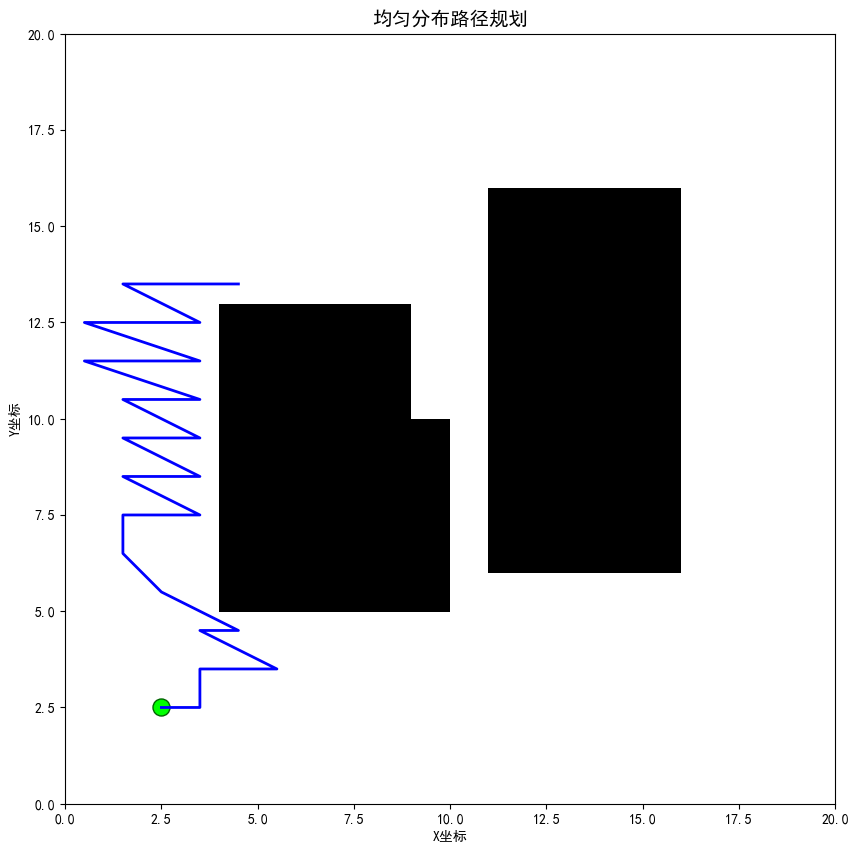

In [104]:
#均匀分布路径规划
import numpy as np
import matplotlib.pyplot as plt

# 参数设置（保留原始参数）
GRID_SIZE = 20
POP_SIZE = 100
GEN_MAX = 200
PATH_LENGTH = 30
OBSTACLE_NUM = 5
START_POS = np.array([2, 2])
MUTATION_RATE = 0.4

np.random.seed(18)

class SearchEnvironment:
    def __init__(self):
        # 生成随机障碍物
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.uint8)
        for _ in range(OBSTACLE_NUM):
            x, y = np.random.randint(5, GRID_SIZE-5, 2)
            self.grid[max(0,x-2):x+3, max(0,y-2):y+3] = 1
            
        # 生成均匀目标概率图
        self.target_prob = np.ones_like(self.grid, dtype=np.float32)
        self.target_prob[self.grid == 1] = 0.0  # 障碍物区域清零
        self.target_prob /= self.target_prob.sum()  # 归一化

class GeneticPathPlanner:
    def __init__(self, env):
        self.env = env
        self.population = []
        self.best_path = None

    def get_neighbors(self, pos):
        """8邻域坐标生成（保留障碍物检测）"""
        deltas = np.array([[-1,0], [1,0], [0,-1], [0,1],
                         [-1,-1], [-1,1], [1,-1], [1,1]])
        neighbors = pos + deltas
        valid = (neighbors >= 0) & (neighbors < GRID_SIZE)
        valid = valid.all(axis=1)
        valid_neighbors = neighbors[valid]
        obstacle_free = self.env.grid[valid_neighbors[:,0], valid_neighbors[:,1]] == 0
        return valid_neighbors[obstacle_free]

    def generate_path(self):
        """改进路径生成策略"""
        path = [START_POS.copy()]
        current = START_POS.copy()
        
        for _ in range(PATH_LENGTH-1):
            neighbors = self.get_neighbors(current)
            if len(neighbors) == 0:
                current = np.clip(current + np.random.randint(-1,2,2), 0, GRID_SIZE-1)
            else:
                # 均匀概率选择
                probs = self.env.target_prob[neighbors[:,0], neighbors[:,1]]
                probs /= probs.sum()
                current = neighbors[np.random.choice(len(neighbors), p=probs)]
            
            path.append(current.copy())
                
        while len(path) < PATH_LENGTH:
            path.append(path[-1].copy())
        return np.array(path)

    def evaluate(self, path):
        """适应度函数改造"""
        # 路径有效性检查
        valid = np.all(self.env.grid[path[:,0].astype(int), path[:,1].astype(int)] == 0)
        
        # 新增覆盖度指标（替代目标接近度）
        unique_coverage = len(np.unique(path, axis=0)) / (GRID_SIZE**2 - OBSTACLE_NUM)
        
        # 路径平滑度
        dir_changes = np.linalg.norm(path[1:] - path[:-1], axis=1)
        smoothness = 1 / (1 + np.std(dir_changes))
        
        # 路径重复率惩罚
        _, counts = np.unique(path, axis=0, return_counts=True)
        repeat_penalty = np.mean(counts > 1)
        
        return (valid * 1000 + 
                unique_coverage * 800 + 
                smoothness * 300 - 
                repeat_penalty * 500)

    def evolve(self):
        """进化流程优化"""
        # 初始化种群
        self.population = [self.generate_path() for _ in range(POP_SIZE)]
        
        for gen in range(GEN_MAX):
            # 评估适应度
            fitness = np.array([self.evaluate(p) for p in self.population])
            
            # 锦标赛选择
            selected = []
            for _ in range(POP_SIZE):
                candidates = np.random.choice(POP_SIZE, 3)
                winner = candidates[np.argmax(fitness[candidates])]
                selected.append(self.population[winner])
            
            # 两点交叉与变异
            new_pop = []
            for i in range(0, POP_SIZE, 2):
                p1, p2 = selected[i], selected[i+1]
                pt1, pt2 = sorted(np.random.randint(1, PATH_LENGTH-1, 2))
                child1 = np.concatenate([p1[:pt1], p2[pt1:pt2], p1[pt2:]])
                child2 = np.concatenate([p2[:pt1], p1[pt1:pt2], p2[pt2:]])
                new_pop.extend([child1, child2])

            # 导向型变异
            for i in range(POP_SIZE):
                if np.random.rand() < MUTATION_RATE:
                    mut_point = np.random.randint(1, PATH_LENGTH-1)
                    neighbors = self.get_neighbors(new_pop[i][mut_point-1])
                    if len(neighbors) > 0:
                        new_pop[i][mut_point] = neighbors[np.argmax(
                            self.env.target_prob[neighbors[:,0], neighbors[:,1]])]
            
            # 精英保留策略
            self.population = new_pop[:POP_SIZE-1] + [self.population[np.argmax(fitness)]]

        self.best_path = self.population[np.argmax(fitness)]
        return self.best_path

# 可视化部分（保留原始实现）
env = SearchEnvironment()
planner = GeneticPathPlanner(env)
best_path = planner.evolve()

plt.figure(figsize=(10,10))
plt.imshow(env.grid, cmap='Greys', origin='lower', 
          extent=[0, GRID_SIZE, 0, GRID_SIZE])

# 绘制路径
unique_path = np.unique(best_path, axis=0)
plt.plot(unique_path[:,1]+0.5, unique_path[:,0]+0.5, 'b-', lw=2)
plt.scatter(START_POS[1]+0.5, START_POS[0]+0.5, 
           c='lime', s=150, edgecolors='darkgreen')

plt.title('均匀分布路径规划', fontsize=14)
plt.xlabel('X坐标')
plt.ylabel('Y坐标')
plt.show()

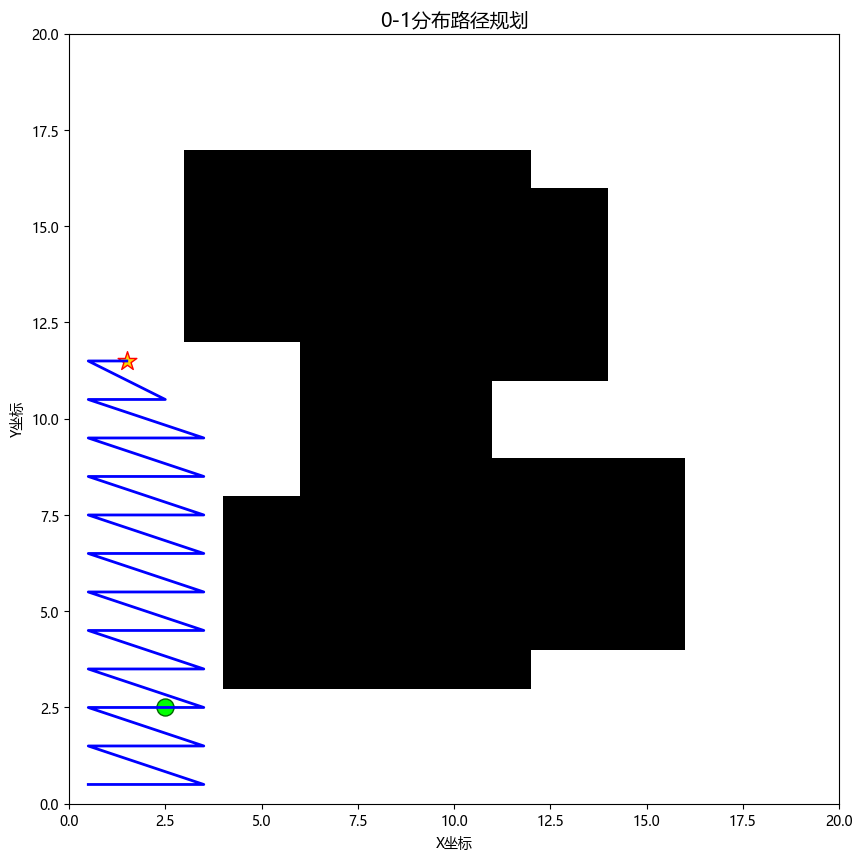

In [3]:
#0-1分布
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
GRID_SIZE = 20
POP_SIZE = 100
GEN_MAX = 200
PATH_LENGTH = 50
OBSTACLE_NUM = 8
START_POS = np.array([2, 2])
TARGET_NUM = 1
MUTATION_RATE = 0.2  # 提升变异概率

np.random.seed(10)

class SearchEnvironment:
    def __init__(self):
        # 生成随机障碍物（移除固定随机种子）
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.uint8)
        for _ in range(OBSTACLE_NUM):
            x, y = np.random.randint(5, GRID_SIZE-5, 2)
            self.grid[max(0,x-2):x+3, max(0,y-2):y+3] = 1
            
        # 生成随机目标点
        self.targets = []
        while len(self.targets) < TARGET_NUM:
            pos = np.random.randint(0, GRID_SIZE, 2)
            if self.grid[pos[0], pos[1]] == 0:
                self.targets.append(pos)
        
        # 目标概率图
        self.target_prob = np.zeros_like(self.grid, dtype=np.float32)
        for t in self.targets:
            self.target_prob[t[0], t[1]] = 1.0

class GeneticPathPlanner:
    def __init__(self, env):
        self.env = env
        self.population = []
        self.best_path = None

    def get_neighbors(self, pos):
        """获取8邻域有效坐标（增加随机性）"""
        deltas = np.array([[-1,0], [1,0], [0,-1], [0,1],
                         [-1,-1], [-1,1], [1,-1], [1,1]])
        neighbors = pos + deltas
        valid = (neighbors >= 0) & (neighbors < GRID_SIZE)
        valid = valid.all(axis=1)
        valid_neighbors = neighbors[valid]
        obstacle_free = self.env.grid[valid_neighbors[:,0], valid_neighbors[:,1]] == 0
        return valid_neighbors[obstacle_free]

    def generate_path(self):
        """改进路径生成（增加随机探索）"""
        path = [START_POS.copy()]
        current = START_POS.copy()
        
        for _ in range(PATH_LENGTH-1):
            neighbors = self.get_neighbors(current)
            if len(neighbors) == 0:
                # 随机方向修复
                current = np.clip(current + np.random.randint(-1,2,2), 0, GRID_SIZE-1)
            else:
                # 引入概率选择（参考网页2的轮盘赌思想）
                probs = self.env.target_prob[neighbors[:,0], neighbors[:,1]] + 0.1  # 防止零概率
                probs /= probs.sum()
                current = neighbors[np.random.choice(len(neighbors), p=probs)]
            
            path.append(current.copy())
            if any(np.all(current == t) for t in self.env.targets):
                break
                
        while len(path) < PATH_LENGTH:
            path.append(path[-1].copy())
        return np.array(path)

    def evaluate(self, path):
        """改进适应度函数（参考网页2的惩罚机制）"""
        # 路径有效性检查（严格碰撞检测）
        valid = np.all(self.env.grid[path[:,0].astype(int), path[:,1].astype(int)] == 0)
        
        # 目标接近度（多目标处理）
        min_dists = [np.min(np.linalg.norm(path - t, axis=1)) for t in self.env.targets]
        proximity = np.exp(-np.mean(min_dists))
        
        # 路径长度惩罚
        unique_path = np.unique(path, axis=0, return_index=True)[0]
        length_penalty = len(unique_path)/PATH_LENGTH
        
        # 方向变化惩罚（参考网页44）
        dir_changes = np.linalg.norm(path[1:] - path[:-1], axis=1)
        smoothness = 1 / (1 + np.std(dir_changes))
        
        return (valid * 1000 + 
                proximity * 500 + 
                smoothness * 200 + 
                length_penalty * 300)

    def evolve(self):
        """改进进化流程（参考网页34的混合算法思想）"""
        # 初始化多样化种群
        self.population = [self.generate_path() for _ in range(POP_SIZE)]
        best_fitness = -float('inf')
        
        for gen in range(GEN_MAX):
            # 评估适应度
            fitness = np.array([self.evaluate(p) for p in self.population])
            
            # 动态记录最优（参考网页44）
            current_best_idx = np.argmax(fitness)
            if fitness[current_best_idx] > best_fitness:
                best_fitness = fitness[current_best_idx]
                self.best_path = self.population[current_best_idx].copy()
                #print(f"Gen {gen}: New best fitness {best_fitness:.1f}")
            
            # 锦标赛选择（参考网页2）
            selected = []
            for _ in range(POP_SIZE):
                candidates = np.random.choice(POP_SIZE, 3)
                winner = candidates[np.argmax(fitness[candidates])]
                selected.append(self.population[winner])
            
            # 顺序交叉（参考网页63的路径连续性要求）
            new_pop = []
            for i in range(0, POP_SIZE, 2):
                p1, p2 = selected[i], selected[i+1]
                if np.random.rand() < 0.8:  # 交叉概率
                    # 两点交叉
                    pt1, pt2 = sorted(np.random.randint(1, PATH_LENGTH-1, 2))
                    child1 = np.concatenate([p1[:pt1], p2[pt1:pt2], p1[pt2:]])
                    child2 = np.concatenate([p2[:pt1], p1[pt1:pt2], p2[pt2:]])
                    new_pop.extend([child1, child2])
                else:
                    new_pop.extend([p1, p2])
            
            # 增强变异（参考网页64的路径优化）
            for i in range(POP_SIZE):
                if np.random.rand() < MUTATION_RATE:
                    # 多类型变异
                    mut_type = np.random.choice(['replace', 'insert', 'delete'])
                    # 替换变异
                    if mut_type == 'replace' and len(new_pop[i]) > 2:
                        mut_point = np.random.randint(1, len(new_pop[i])-1)
                        neighbors = self.get_neighbors(new_pop[i][mut_point-1])
                        if len(neighbors) > 0:
                            new_pop[i][mut_point] = neighbors[np.random.randint(len(neighbors))]
                    # 插入变异
                    elif mut_type == 'insert' and len(new_pop[i]) < PATH_LENGTH:
                        mut_point = np.random.randint(1, len(new_pop[i]))
                        new_point = (new_pop[i][mut_point-1] + new_pop[i][mut_point])//2
                        new_pop[i] = np.insert(new_pop[i], mut_point, new_point, axis=0)
                    # 删除变异    
                    elif mut_type == 'delete' and len(new_pop[i]) > 2:
                        del_point = np.random.randint(1, len(new_pop[i])-1)
                        new_pop[i] = np.delete(new_pop[i], del_point, axis=0)
            
            # 精英保留+随机注入（参考网页34）
            self.population = new_pop[:POP_SIZE-2] + [self.best_path, self.generate_path()]
            
        return self.best_path

# 运行与可视化
env = SearchEnvironment()
planner = GeneticPathPlanner(env)
best_path = planner.evolve()

plt.figure(figsize=(10,10))
plt.imshow(env.grid, cmap='Greys', origin='lower', 
          extent=[0, GRID_SIZE, 0, GRID_SIZE])

# 绘制目标点
for t in env.targets:
    plt.scatter(t[1]+0.5, t[0]+0.5, c='gold', s=200, marker='*', edgecolors='red')

# 绘制路径
unique_path = np.unique(best_path, axis=0)
plt.plot(unique_path[:,1]+0.5, unique_path[:,0]+0.5, 'b-', lw=2)
plt.scatter(START_POS[1]+0.5, START_POS[0]+0.5, 
           c='lime', s=150, edgecolors='darkgreen')

plt.title('0-1分布路径规划', fontsize=14)
plt.xlabel('X坐标')
plt.ylabel('Y坐标')
plt.show()

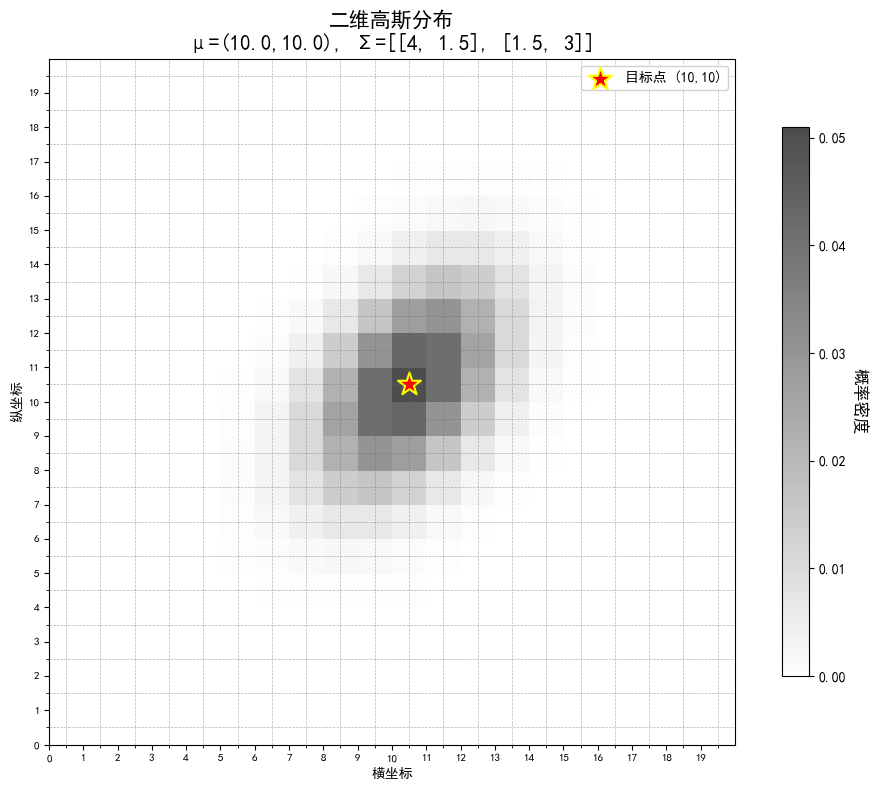

In [4]:
#高斯概率分布模拟
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 设置全局字体（Windows常用）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 参数设置
GRID_SIZE = 20
np.random.seed(2)

# 生成高斯分布参数
mean = [GRID_SIZE/2, GRID_SIZE/2]  # 中心点
cov = [[4, 1.5], [1.5, 3]]        # 协方差矩阵

# 生成概率密度矩阵
x, y = np.mgrid[0:GRID_SIZE:1, 0:GRID_SIZE:1]
pos = np.dstack((x, y))
gaussian_grid = multivariate_normal(mean, cov).pdf(pos)

# 获取最大概率点
max_prob = np.unravel_index(np.argmax(gaussian_grid), gaussian_grid.shape)

# 可视化设置
plt.figure(figsize=(10,8))
ax = plt.gca()

# 显示概率分布热力图
im = ax.imshow(gaussian_grid,  # 转置对齐坐标系
               cmap='grey_r', 
               origin='lower',
               extent=[0, GRID_SIZE, 0, GRID_SIZE],
               alpha=0.7)

# 设置网格线（参考网页3和40的网格设置）
ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
ax.grid(which="minor", 
        color='dimgray', 
        linestyle='--', 
        linewidth=0.5,
        alpha=0.5)  # 半透明处理

# 主刻度设置
ax.set_xticks(np.arange(0, GRID_SIZE, 1))
ax.set_yticks(np.arange(0, GRID_SIZE, 1))
ax.tick_params(axis='both', which='major', labelsize=8)

# 标注目标点（概率最高点）
ax.scatter(max_prob[1]+0.5, max_prob[0]+0.5,
          c='red', 
          s=300, 
          marker='*',
          edgecolors='yellow',
          linewidth=1.5,
          label=f'目标点 ({max_prob[0]},{max_prob[1]})')

# 添加颜色条
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('概率密度', rotation=270, labelpad=15, fontsize=12)
'''
# 辅助等高线（半透明白色）
X, Y = np.mgrid[0:GRID_SIZE:100j, 0:GRID_SIZE:100j]
contour_levels = np.linspace(gaussian_grid.min(), gaussian_grid.max(), 10)
ax.contour(X, Y, multivariate_normal(mean, cov).pdf(np.dstack((X,Y))).T,
          levels=contour_levels, 
          colors='white', 
          alpha=0.3)
'''
# 图例和标题设置
plt.legend(loc='upper right', framealpha=0.9)
plt.title(f'二维高斯分布\nμ=({mean[0]},{mean[1]}), Σ={cov}', fontsize=15)
plt.xlabel('横坐标', fontsize=10)
plt.ylabel('纵坐标', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Jianze\AppData\Local\Temp\ipykernel_17300\3308795436.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', framealpha=0.9)


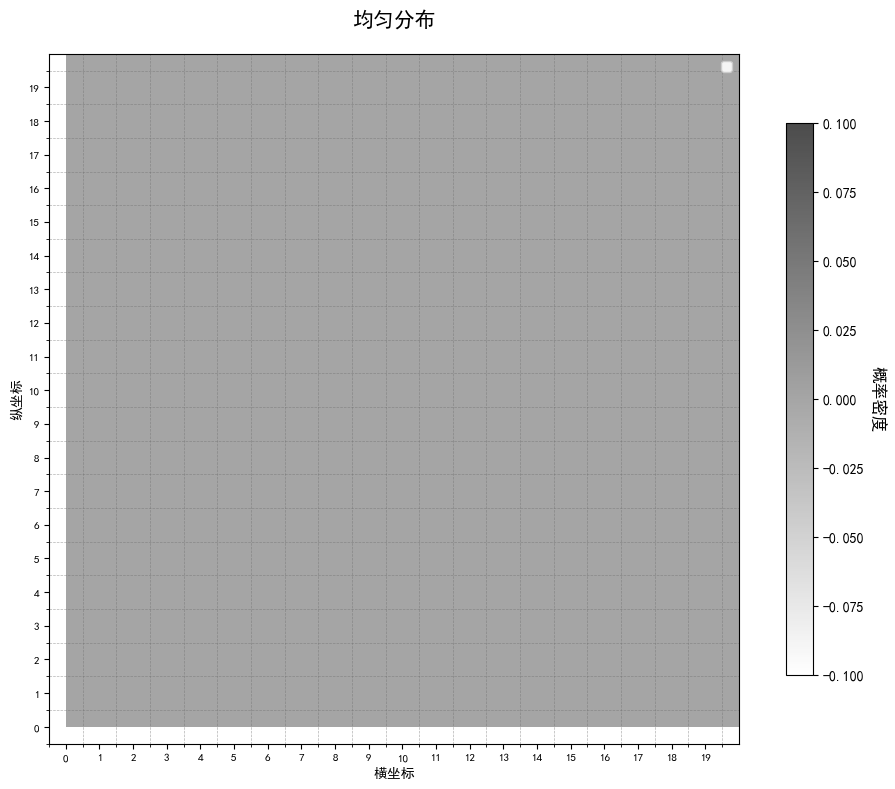

In [ ]:
#0-1概率分布模拟
import numpy as np
import matplotlib.pyplot as plt

# 设置全局字体（Windows常用）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# 参数设置
GRID_SIZE = 20
p = 0.1  # 成功概率
np.random.seed(11)
#10为0-1分布
# 生成0-1分布矩阵
binary_grid = np.random.binomial(1, 0.0001, (GRID_SIZE, GRID_SIZE))

# 获取目标位置
targets = np.argwhere(binary_grid == 1)
if len(targets) > 0:
    main_target = targets[0]  # 取第一个目标点
else:
    main_target = (GRID_SIZE//2, GRID_SIZE//2)  # 保底中心点

# 可视化设置
plt.figure(figsize=(10,8))
ax = plt.gca()

# 显示概率分布热力图（参考网页39的imshow用法）
im = ax.imshow(binary_grid, 
               cmap='gray_r',  # 反色灰度更清晰
               origin='lower', 
               extent=[0, GRID_SIZE, 0, GRID_SIZE],
               alpha=0.7)

# 设置网格线（参考网页3和40的网格设置）
ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
ax.grid(which="minor", 
        color='dimgray', 
        linestyle='--', 
        linewidth=0.5,
        alpha=0.5)  # 半透明处理

# 主刻度设置（参考网页40）
ax.set_xticks(np.arange(0, GRID_SIZE, 1))
ax.set_yticks(np.arange(0, GRID_SIZE, 1))
ax.tick_params(axis='both', which='major', labelsize=8)

# 标注目标点（参考网页23的概率分布可视化）
'''
ax.scatter(main_target[1]+0.5, main_target[0]+0.5,  # 坐标偏移0.5对齐网格中心
          c='red', 
          s=200, 
          marker='*',
          edgecolors='gold',
          linewidth=1.5,
          label=f'目标点 ({main_target[0]},{main_target[1]})')
'''
# 添加颜色条（参考网页39的colorbar使用）
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('概率密度', rotation=270, labelpad=15, fontsize=12)

# 图例和标题设置
plt.legend(loc='upper right', framealpha=0.9)
plt.title(f'均匀分布', fontsize=15, pad=20)
plt.xlabel('横坐标', fontsize=10)
plt.ylabel('纵坐标', fontsize=10)

# 显示效果优化（参考网页44的坐标轴处理）
plt.tight_layout()
plt.show()

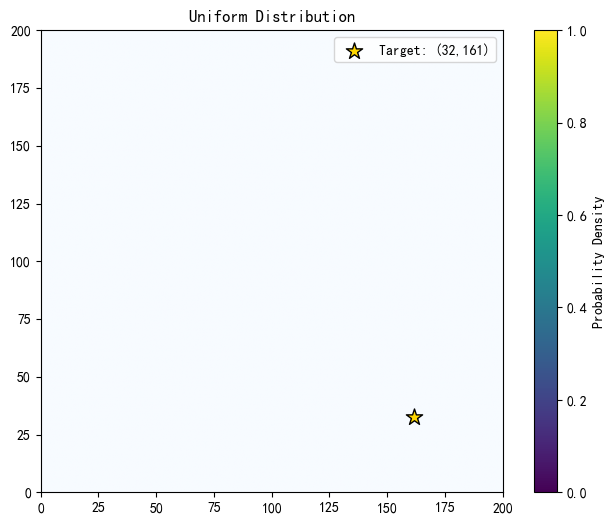

In [81]:
from scipy import stats

# 生成均匀分布
uniform_grid = np.ones((GRID_SIZE, GRID_SIZE)) / (GRID_SIZE**2)

# 随机选择目标位置
target = np.random.randint(0, GRID_SIZE, 2)

# 可视化
plt.figure(figsize=(8,6))
plt.imshow(uniform_grid, cmap='Blues', origin='lower', 
          extent=[0, GRID_SIZE, 0, GRID_SIZE])
plt.scatter(target[1]+0.5, target[0]+0.5, c='gold', s=150, 
           marker='*', edgecolors='black', label=f'Target: ({target[0]},{target[1]})')
plt.colorbar(label='Probability Density')
plt.title('Uniform Distribution')
plt.legend()
plt.show()

Search Start: (5, 3)
探测网格 (6, 4) 的累计发现概率: 0.000000
探测网格 (7, 4) 的累计发现概率: 0.000000
探测网格 (8, 5) 的累计发现概率: 0.000000
探测网格 (8, 6) 的累计发现概率: 0.000000
探测网格 (9, 7) 的累计发现概率: 0.000000
探测网格 (10, 8) 的累计发现概率: 0.000006
探测网格 (10, 9) 的累计发现概率: 0.017125
探测网格 (10, 10) 的累计发现概率: 0.542960
探测网格 (10, 11) 的累计发现概率: 0.623899
探测网格 (11, 11) 的累计发现概率: 0.443194
探测网格 (10, 10) 的累计发现概率: 1.089054
探测网格 (10, 11) 的累计发现概率: 1.187370
探测网格 (10, 10) 的累计发现概率: 1.748018
探测网格 (10, 11) 的累计发现概率: 1.910269
探测网格 (11, 11) 的累计发现概率: 0.882100
探测网格 (10, 10) 的累计发现概率: 2.308225
探测网格 (11, 11) 的累计发现概率: 1.380432
探测网格 (10, 11) 的累计发现概率: 2.749113
探测网格 (10, 10) 的累计发现概率: 2.929306


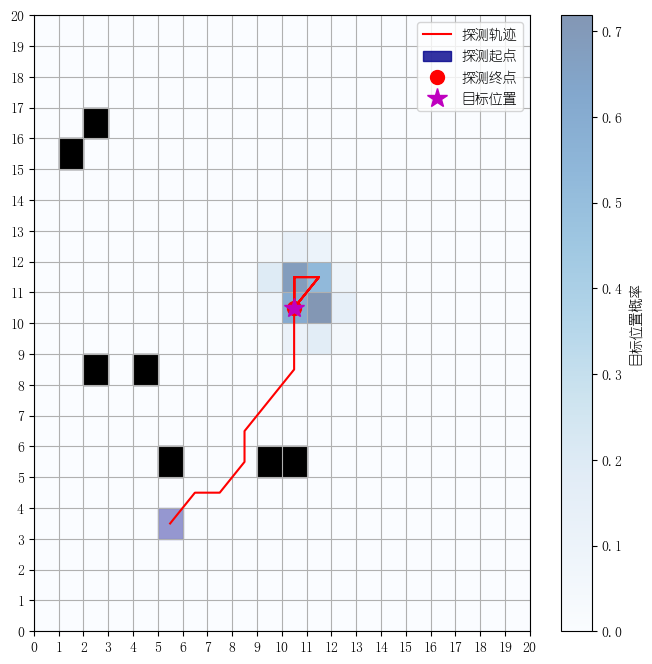

In [ ]:
#贪婪算法0-1分布
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from scipy.stats import binom
#新增加的两行
import matplotlib
matplotlib.rc("font",family='YouYuan')

# 设置网格大小
grid_size = 20

# 探测概率固定
detection_probability = 0.8  # 假设探测概率是 0.8

# 直接设定目标位置
target_position = (10, 10)  # 目标在网格 (10, 10) 处

# 定义障碍物的位置
obstacles = [(10, 5), (5, 5), (4, 8), (2, 16), (2,8), (9, 5), (1, 15)]

# 固定探测起点
search_start = (5, 3)  # 探测起点
print("Search Start:", search_start)

# 生成网格中心点坐标
def get_grid_centers(grid_size):
    return [(i + 0.5, j + 0.5) for i in range(grid_size) for j in range(grid_size)]

grid_centers = get_grid_centers(grid_size)

# 生成随机的探测起点
def generate_random_start(grid_size):
    while True:
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        if (x, y) not in obstacles:  # 确保起点不在障碍物上
            return (x, y)

# KDE 核密度估计方法：生成目标当前位置的概率分布图
def generate_kde_probability_map(target_position, grid_size, bw_method=1, resolution_factor=5):
    """
    使用 KDE 估算目标当前位置的概率分布图，并优化精度
    :param target_position: 目标位置 (target_x, target_y)
    :param grid_size: 网格大小
    :param bw_method: KDE 的带宽参数
    :param resolution_factor: 网格分辨率因子，用于提高网格精度
    :return: 归一化后的概率分布 P_t
    """
    # 1. 生成一组以目标位置为中心的粒子
    target_x, target_y = target_position
    particles = [(target_x + random.gauss(0, 0.5), target_y + random.gauss(0, 0.5)) for _ in range(100)]

    # 2. 将粒子位置转换为 numpy 数组并进行转置
    particle_positions = np.array(particles).T

    # 3. 使用指定带宽的核密度估计
    kde = gaussian_kde(particle_positions, bw_method=bw_method)

    # 4. 提高网格分辨率，减少插值误差
    resolution = grid_size * resolution_factor  # 增加网格分辨率
    x, y = np.meshgrid(np.linspace(0, grid_size - 1, resolution),
                       np.linspace(0, grid_size - 1, resolution))

    # 5. 创建网格点并进行计算
    grid_points = np.vstack([x.ravel(), y.ravel()])
    P_t = kde(grid_points).reshape(resolution, resolution)

    # 6. 归一化概率分布，确保最大值为 1，避免浮动误差
    P_t /= P_t.max()

    # 7. 可选：对概率图进行滤波，进一步平滑分布，减少小误差
    P_t = gaussian_filter(P_t, sigma=1)

    # 8. 恢复到原始分辨率并裁剪数据到原始网格大小
    P_t_resized = np.array(P_t[::resolution_factor, ::resolution_factor])

    # 9. 返回归一化后的概率分布图
    return P_t_resized

# 计算累计探测概率
def calculate_cumulative_detection_probability(P_t, D, N, M):
    """
    计算累计探测概率
    :param P_t: 目标在网格 (x, y) 处的存在概率
    :param D: 单次探测成功的概率
    :param N: 探测次数
    :param M: 成功探测的最小次数
    :return: 累计探测概率
    """
    cumulative_prob = 0.0
    # 确保 P_t * D 的值在 [0, 1] 范围内
    prob = min(max(P_t * D, 0.0), 1.0)  # 将 P_t * D 限制在 [0, 1] 范围内
    for k in range(M, N + 1):
        cumulative_prob += binom.pmf(k, N, prob)
    return cumulative_prob

# 生成搜索路径
def generate_search_path(start, steps, target_position, exploration_factor=0.5, N=5, M=3):
    path = [start]
    grid_cumulative_prob = np.zeros((grid_size, grid_size))  # 记录每个网格的累计发现概率

    for _ in range(steps - 1):
        x, y = path[-1]
        best_next = None
        best_cumulative_prob = -1

        # 八个方向的可能性
        possible_moves = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
                          (x + 1, y + 1), (x - 1, y + 1), (x + 1, y - 1), (x - 1, y - 1)]

        # 过滤掉越界的移动和障碍物
        valid_moves = [(nx, ny) for nx, ny in possible_moves
                       if 0 <= nx < grid_size and 0 <= ny < grid_size and (nx, ny) not in obstacles]

        # 如果没有有效移动，则保持当前位置
        if not valid_moves:
            path.append((x, y))
            continue

        # 计算每个有效移动的累计探测概率
        move_cumulative_probs = []
        for nx, ny in valid_moves:
            # 获取当前位置的目标位置概率
            P_t = generate_kde_probability_map(target_position, grid_size)
            target_prob = P_t[int(ny), int(nx)]  # 获取当前位置的目标位置概率

            # 计算累计探测概率
            cumulative_detection_prob = calculate_cumulative_detection_probability(target_prob, detection_probability, N, M)

            # 探索性：一定概率选择次优路径（避免贪婪陷入局部最优）
            if random.random() < exploration_factor:
                cumulative_detection_prob = cumulative_detection_prob * random.uniform(0.5, 1.5)

            move_cumulative_probs.append(((nx, ny), cumulative_detection_prob))

        # 按累计探测概率从高到低排序
        move_cumulative_probs.sort(key=lambda x: -x[1])

        # 依次选择最优、次优、第三优……直到找到一个有效的移动方向
        for move, cumulative_prob in move_cumulative_probs:
            nx, ny = move
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                best_next = (nx, ny)
                grid_cumulative_prob[ny, nx] += cumulative_prob  # 更新网格的累计发现概率
                print(f"探测网格 ({nx}, {ny}) 的累计发现概率: {grid_cumulative_prob[ny, nx]:.6f}")  # 在控制台显示
                break

        # 如果没有找到有效移动（理论上不会发生，因为 valid_moves 已经过滤了越界）
        if best_next is None:
            best_next = (x, y)

        path.append(best_next)

    return [(x + 0.5, y + 0.5) for x, y in path], grid_cumulative_prob  # 转换为中心点，返回累计发现概率


# 生成探测轨迹
search_path, grid_cumulative_prob = generate_search_path(search_start, steps=20, target_position=target_position, exploration_factor=0.5, N=5, M=3)

# 生成目标概率分布图
P_t = generate_kde_probability_map(target_position, grid_size)

# 绘制探测轨迹
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制探测轨迹（红色连线）
search_x, search_y = zip(*search_path)
ax.plot(search_x, search_y, 'r-', label='探测轨迹')  # 红色连线

# 标记探测起点为深蓝色方格
start_x, start_y = search_start
ax.add_patch(plt.Rectangle((start_x, start_y), 1, 1, color='darkblue', alpha=0.8, label='探测起点'))  # 深蓝色方格表示起点

# 标记探测终点
end_x, end_y = search_path[-1]
ax.plot(end_x, end_y, 'ro', markersize=10, label='探测终点')  # 用红色圆点标记终点

# 绘制目标概率分布图
c = ax.pcolormesh(P_t, cmap='Blues', alpha=0.5)
fig.colorbar(c, ax=ax, label="目标位置概率")

# 绘制目标位置为紫色五角星
target_x, target_y = target_position
ax.plot(target_x + 0.5, target_y + 0.5, 'm*', markersize=15, label='目标位置')  # 紫色五角星表示目标

# 绘制障碍物
for (x, y) in obstacles:
    ax.add_patch(plt.Rectangle((x, y), 1, 1, color='black', alpha=1))  # 用黑色方块表示障碍物，alpha=1 确保完全可见

# 设置图形属性
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_xticks(np.arange(0, grid_size + 1, 1))
ax.set_yticks(np.arange(0, grid_size + 1, 1))
ax.grid(True)
ax.legend()

# 添加点击事件：点击网格显示累计发现概率
def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        if 0 <= x < grid_size and 0 <= y < grid_size:
            print(f"网格 ({x}, {y}) 的累计发现概率: {grid_cumulative_prob[y, x]:.6f}")

# 绑定点击事件
fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Search Start: (10, 10)
目标位置 (11, 10) 的目标概率: 0.0025829228252272525
目标位置 (11, 10) 的累计探测概率: 8.795432056100671e-08
目标位置 (9, 10) 的目标概率: 0.003853268062775382
目标位置 (9, 10) 的累计探测概率: 2.91573007529168e-07
目标位置 (10, 11) 的目标概率: 0.0025829228252272525
目标位置 (10, 11) 的累计探测概率: 8.795432056100671e-08
目标位置 (10, 9) 的目标概率: 0.003853268062775382
目标位置 (10, 9) 的累计探测概率: 2.91573007529168e-07
目标位置 (11, 11) 的目标概率: 0.0020728441209312237
目标位置 (11, 11) 的累计探测概率: 4.5487178203254965e-08
目标位置 (9, 11) 的目标概率: 0.0030923200539657077
目标位置 (9, 11) 的累计探测概率: 1.5083783897984214e-07
目标位置 (11, 9) 的目标概率: 0.0030923200539657077
目标位置 (11, 9) 的累计探测概率: 1.5083783897984214e-07
目标位置 (9, 9) 的目标概率: 0.004613199429517428
目标位置 (9, 9) 的累计探测概率: 4.998841366689643e-07
目标位置 (10, 9) 的目标概率: 0.003853268062775382
目标位置 (10, 9) 的累计探测概率: 2.91573007529168e-07
目标位置 (8, 9) 的目标概率: 0.005306442432677006
目标位置 (8, 9) 的累计探测概率: 7.601700336989923e-07
目标位置 (9, 10) 的目标概率: 0.003853268062775382
目标位置 (9, 10) 的累计探测概率: 2.91573007529168e-07
目标位置 (9, 8) 的目标概率: 0.005306442432677

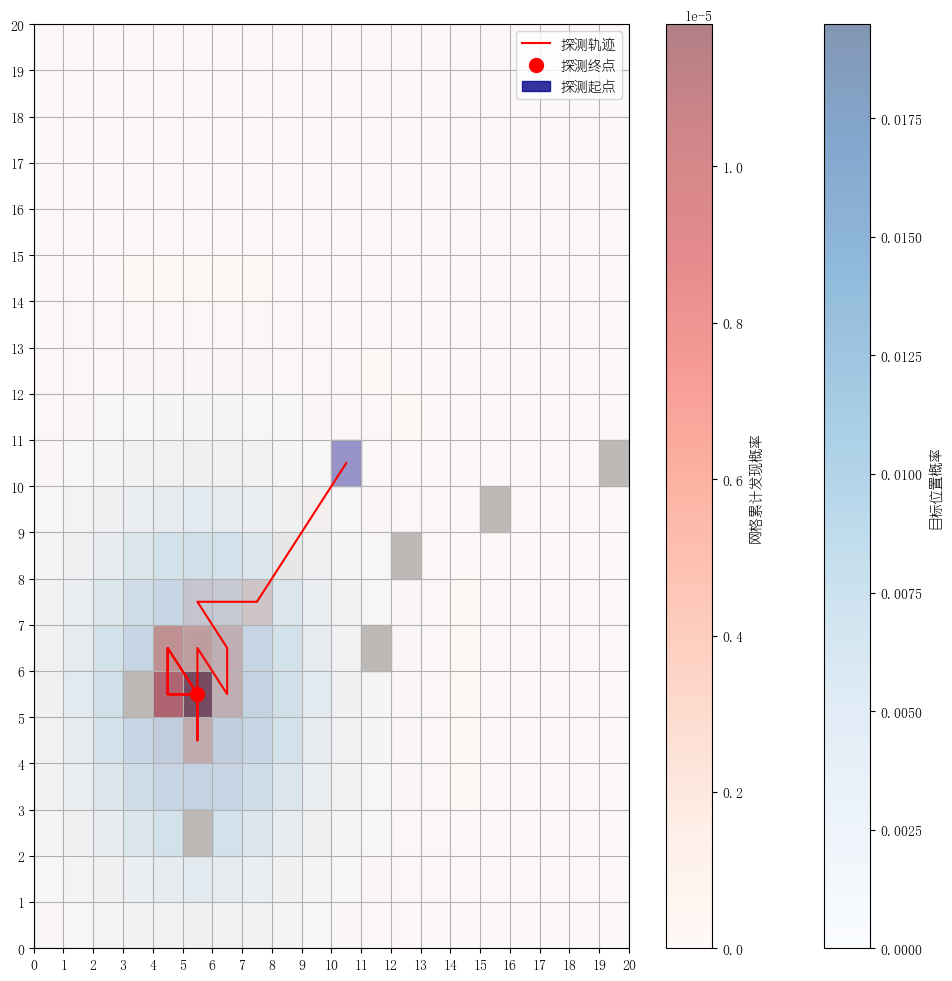

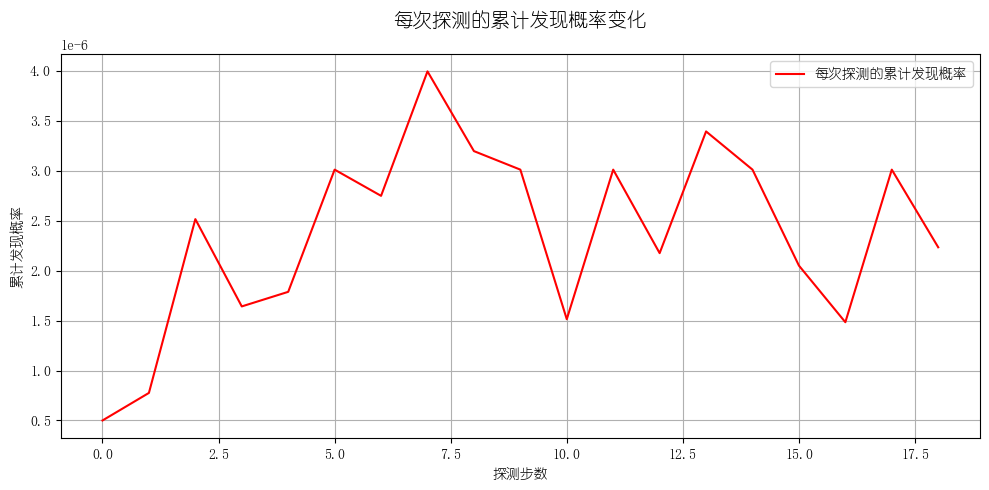

In [ ]:
#贪婪算法高斯分布
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
#新增加的两行
import matplotlib
matplotlib.rc("font",family='YouYuan')

# 设置网格大小
grid_size = 20

# 探测概率固定
detection_probability = 0.8  # 假设探测概率是 0.8

# 固定探测起点
search_start = (10, 10)  # 探测起点
print("Search Start:", search_start)

# 定义障碍物的位置
obstacles = [(5, 2), (11, 6), (3, 5), (12, 8), (15, 9), (19, 10)]  # 障碍物的位置列表

# 生成网格中心点坐标
def get_grid_centers(grid_size):
    return [(i + 0.5, j + 0.5) for i in range(grid_size) for j in range(grid_size)]

grid_centers = get_grid_centers(grid_size)

# 生成高斯核分布的目标概率分布图
def generate_gaussian_probability_map(grid_size, center=None, sigma=3, obstacles=None):
    """
    生成高斯核分布的目标概率分布图
    :param grid_size: 网格大小
    :param center: 高斯分布的中心点，默认为网格中心
    :param sigma: 高斯分布的标准差，控制分布的平滑程度
    :param obstacles: 障碍物位置列表
    :return: 归一化后的概率分布 P_t
    """
    if center is None:
        center = (grid_size // 2, grid_size // 2)  # 默认中心点为网格中心

    # 生成网格坐标
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)

    # 计算高斯分布
    P_t = np.exp(-((xx - center[0])**2 + (yy - center[1])**2) / (2 * sigma**2))

    # 将障碍物所在网格的目标概率设为 0
    if obstacles is not None:
        for (x, y) in obstacles:
            P_t[y, x] = 0

    # 归一化概率分布，确保总和为 1
    P_t /= P_t.sum()

    return P_t

# 计算累计探测概率
def calculate_cumulative_detection_probability(P_t, D, N, M):
    """
    计算累计探测概率
    :param P_t: 目标在网格 (x, y) 处的存在概率
    :param D: 单次探测成功的概率
    :param N: 探测次数
    :param M: 成功探测的最小次数
    :return: 累计探测概率
    """
    cumulative_prob = 0.0
    prob = min(max(P_t * D, 0.0), 1.0)  # 直接使用 P_t * D
    for k in range(M, N + 1):
        cumulative_prob += binom.pmf(k, N, prob)
    return cumulative_prob

# 生成搜索路径
def generate_search_path(start, steps, exploration_factor=0.5, N=5, M=3, center=None, obstacles=None):
    path = [start]
    cumulative_probabilities = []  # 记录每次探测的累计发现概率
    P_t = generate_gaussian_probability_map(grid_size, center=center, sigma=5, obstacles=obstacles)  # 初始概率分布，sigma=5 使分布更平滑
    grid_cumulative_prob = np.zeros((grid_size, grid_size))  # 记录每个网格的累计发现概率

    for _ in range(steps - 1):
        x, y = path[-1]
        best_next = None
        best_cumulative_prob = -1

        # 八个方向的可能性
        possible_moves = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
                          (x + 1, y + 1), (x - 1, y + 1), (x + 1, y - 1), (x - 1, y - 1)]

        # 过滤掉越界的移动和障碍物网格
        valid_moves = [(nx, ny) for nx, ny in possible_moves if 0 <= nx < grid_size and 0 <= ny < grid_size and (nx, ny) not in obstacles]

        # 如果没有有效移动，则保持当前位置
        if not valid_moves:
            path.append((x, y))
            cumulative_probabilities.append(0)  # 无移动，累计概率为 0
            continue

        # 计算每个有效移动的累计探测概率
        move_cumulative_probs = []
        for nx, ny in valid_moves:
            # 获取当前位置的目标位置概率
            target_prob = P_t[int(ny), int(nx)]  # 获取当前位置的目标位置概率
            print(f"目标位置 ({nx}, {ny}) 的目标概率: {target_prob}")

            # 计算累计探测概率
            cumulative_detection_prob = calculate_cumulative_detection_probability(target_prob, detection_probability, N, M)
            print(f"目标位置 ({nx}, {ny}) 的累计探测概率: {cumulative_detection_prob}")

            # 探索性：一定概率选择次优路径（避免贪婪陷入局部最优）
            if random.random() < exploration_factor:
                cumulative_detection_prob = cumulative_detection_prob * random.uniform(0.5, 1.5)

            move_cumulative_probs.append(((nx, ny), cumulative_detection_prob))

        # 按累计探测概率从高到低排序
        move_cumulative_probs.sort(key=lambda x: -x[1])

        # 依次选择最优、次优、第三优……直到找到一个有效的移动方向
        for move, cumulative_prob in move_cumulative_probs:
            nx, ny = move
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                best_next = (nx, ny)
                break

        # 如果没有找到有效移动（理论上不会发生，因为 valid_moves 已经过滤了越界）
        if best_next is None:
            best_next = (x, y)

        # 更新路径
        path.append(best_next)

        # 更新当前网格的累计发现概率
        grid_cumulative_prob[int(best_next[1]), int(best_next[0])] += cumulative_detection_prob  # 直接使用原始值，不放大

        # 更新累计发现概率
        cumulative_probabilities.append(cumulative_detection_prob)

    return [(x + 0.5, y + 0.5) for x, y in path], cumulative_probabilities, grid_cumulative_prob  # 转换为中心点，返回累计发现概率和网格累计概率

# 设置高斯核中心位置
gaussian_center = (5, 5)  # 设置高斯核位置

# 生成探测轨迹
search_path, cumulative_probabilities, grid_cumulative_prob = generate_search_path(
    search_start, steps=20, exploration_factor=0.5, N=5, M=3, center=gaussian_center, obstacles=obstacles  # 增加 steps，降低 exploration_factor
)

# 生成目标概率分布图
P_t = generate_gaussian_probability_map(grid_size, center=gaussian_center, sigma=3, obstacles=obstacles)  # 调整 sigma=3

# 打印目标概率图
print("目标概率图 P_t:")
print(P_t)

# 绘制探测轨迹
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制障碍物
for (x, y) in obstacles:
    ax.add_patch(plt.Rectangle((x, y), 1, 1, color='black', alpha=1))  # 用黑色方块表示障碍物，alpha=1 确保完全可见



# 绘制探测轨迹（红色连线）
search_x, search_y = zip(*search_path)
ax.plot(search_x, search_y, 'r-', label='探测轨迹')  # 红色连线

# 标记探测终点为红色圆圈
end_x, end_y = search_path[-1]
ax.plot(end_x, end_y, 'ro', markersize=10, label='探测终点')  # 红色圆圈表示终点


# 绘制目标概率分布图
c = ax.pcolormesh(P_t, cmap='Blues', alpha=0.5)
fig.colorbar(c, ax=ax, label="目标位置概率")

# 标记探测起点为深蓝色方格
start_x, start_y = search_start
ax.add_patch(plt.Rectangle((start_x, start_y), 1, 1, color='darkblue', alpha=0.8, label='探测起点'))  # 深蓝色方格表示起点


# 绘制每个网格的累计发现概率
grid_cumulative_prob_mesh = ax.pcolormesh(grid_cumulative_prob, cmap='Reds', alpha=0.5)
fig.colorbar(grid_cumulative_prob_mesh, ax=ax, label="网格累计发现概率")

# 设置图形属性
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_xticks(np.arange(0, grid_size + 1, 1))
ax.set_yticks(np.arange(0, grid_size + 1, 1))
ax.grid(True)
ax.legend()



# 添加点击事件
def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        if 0 <= x < grid_size and 0 <= y < grid_size:
            cumulative_prob = grid_cumulative_prob[y, x]
            print(f"网格 ({x}, {y}) 的累计发现概率: {cumulative_prob:.10f}")

# 绑定点击事件
fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# 绘制每次探测的累计发现概率
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_probabilities)), cumulative_probabilities, 'r-', label='每次探测的累计发现概率')
plt.xlabel('探测步数')
plt.ylabel('累计发现概率')
plt.legend()
plt.grid(True)
plt.title("每次探测的累计发现概率变化", fontsize=14, pad=20)  # 添加标题
plt.tight_layout()  # 自动调整布局，避免标题被遮挡
plt.show()

Search Start: (10, 10)
探测网格 (11, 11) 的累计发现概率: 0.086443
探测网格 (11, 10) 的累计发现概率: 0.069258
探测网格 (11, 11) 的累计发现概率: 0.164216
探测网格 (10, 12) 的累计发现概率: 0.087705
探测网格 (11, 12) 的累计发现概率: 0.060286
探测网格 (11, 13) 的累计发现概率: 0.078723
探测网格 (11, 14) 的累计发现概率: 0.060286
探测网格 (11, 15) 的累计发现概率: 0.084370
探测网格 (12, 16) 的累计发现概率: 0.081553
探测网格 (13, 16) 的累计发现概率: 0.060286
探测网格 (12, 16) 的累计发现概率: 0.169025
探测网格 (11, 15) 的累计发现概率: 0.173054
探测网格 (12, 16) 的累计发现概率: 0.259136
探测网格 (12, 17) 的累计发现概率: 0.083786
探测网格 (11, 17) 的累计发现概率: 0.084460
探测网格 (11, 18) 的累计发现概率: 0.060286
探测网格 (12, 17) 的累计发现概率: 0.166033
探测网格 (13, 16) 的累计发现概率: 0.148311
探测网格 (14, 17) 的累计发现概率: 0.074278
探测网格 (13, 18) 的累计发现概率: 0.082326
探测网格 (14, 17) 的累计发现概率: 0.143080
探测网格 (13, 16) 的累计发现概率: 0.235664
探测网格 (12, 17) 的累计发现概率: 0.236753
探测网格 (11, 17) 的累计发现概率: 0.173364
探测网格 (12, 17) 的累计发现概率: 0.297038
探测网格 (11, 16) 的累计发现概率: 0.084661
探测网格 (10, 15) 的累计发现概率: 0.084581
探测网格 (11, 15) 的累计发现概率: 0.258452
探测网格 (12, 16) 的累计发现概率: 0.320580


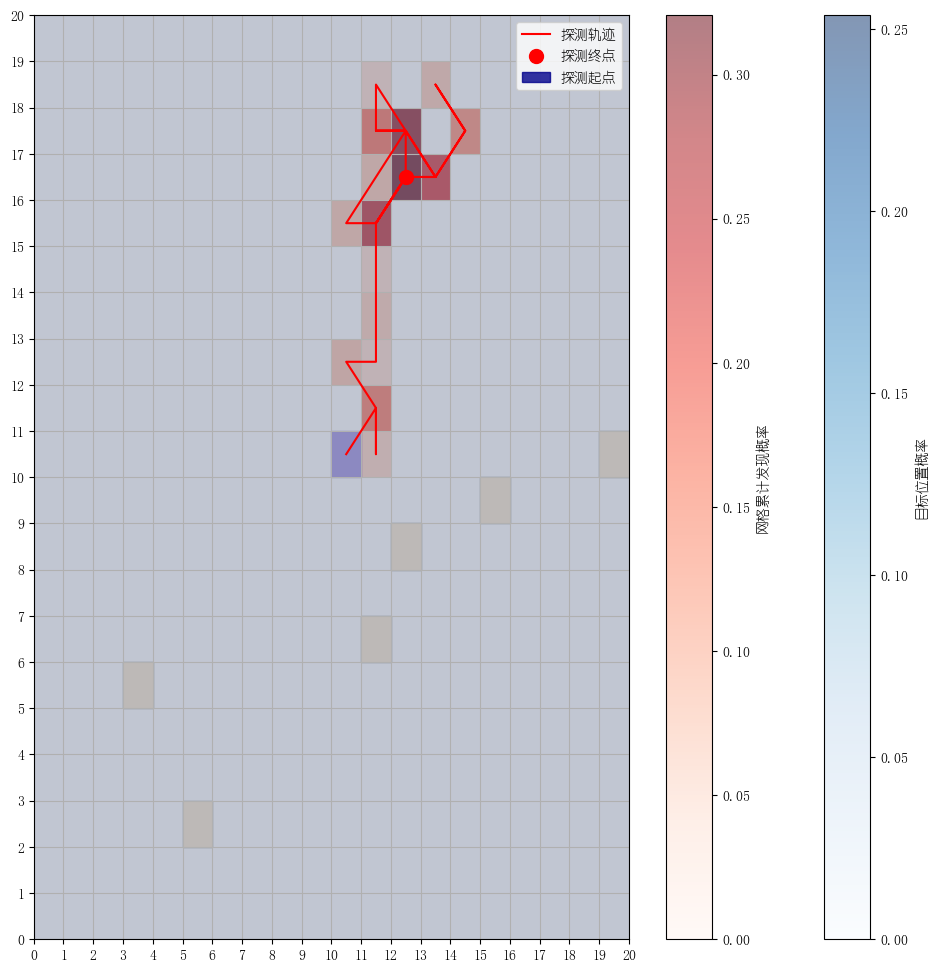

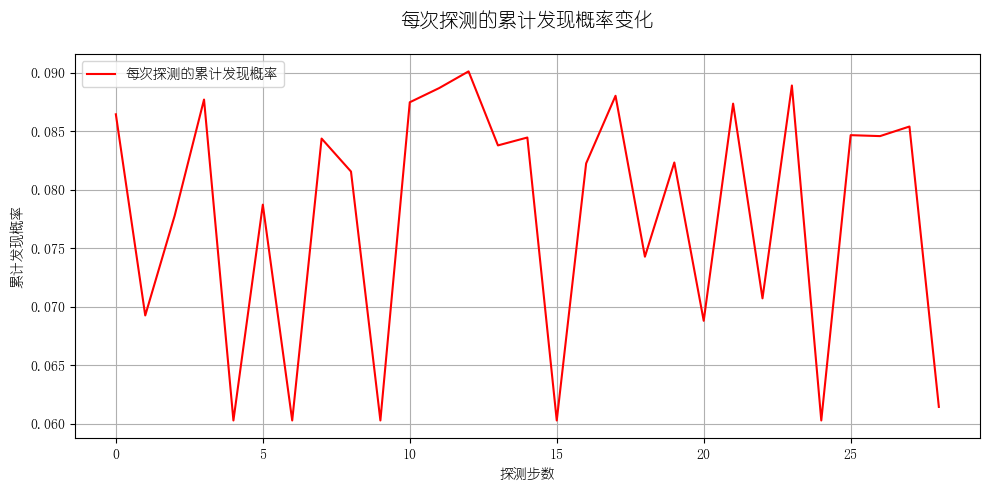

In [7]:
#贪婪算法均匀分布
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
#新增加的两行
import matplotlib
matplotlib.rc("font",family='YouYuan')

# 设置网格大小
grid_size = 20

# 探测概率固定
detection_probability = 0.8  # 假设探测概率是 0.8

# 固定探测起点
search_start = (10, 10)  # 探测起点
print("Search Start:", search_start)

# 生成网格中心点坐标
def get_grid_centers(grid_size):
    return [(i + 0.5, j + 0.5) for i in range(grid_size) for j in range(grid_size)]

grid_centers = get_grid_centers(grid_size)

# 定义障碍物的位置
obstacles = [(5, 2), (11, 6), (3, 5), (12, 8), (15, 9),(19,10)]  # 障碍物的位置列表

# 封装目标分布部分
class TargetDistribution:
    def __init__(self, grid_size, obstacles):
        self.grid_size = grid_size
        self.obstacles = obstacles
        self.P_t = self.generate_uniform_probability_map()

    def generate_uniform_probability_map(self):
        """
        生成均匀分布的目标概率分布图
        :return: 归一化后的概率分布 P_t
        """
        # 生成均匀分布的概率图
        P_t = np.ones((self.grid_size, self.grid_size))

        # 将障碍物所在网格的目标概率设为 0
        for (x, y) in self.obstacles:
            P_t[y, x] = 0

        # 归一化概率分布，确保总和为 1
        P_t /= P_t.sum()

        # 放大数值以减少浮点误差的影响
        P_t *= 100  # 放大 100 倍

        return P_t

    def get_probability_map(self):
        """
        获取目标概率分布图
        :return: 目标概率分布图 P_t
        """
        return self.P_t

# 计算累计探测概率
def calculate_cumulative_detection_probability(P_t, D, N, M):
    """
    计算累计探测概率
    :param P_t: 目标在网格 (x, y) 处的存在概率
    :param D: 单次探测成功的概率
    :param N: 探测次数
    :param M: 成功探测的最小次数
    :return: 累计探测概率
    """
    # 计算单次探测的发现概率
    P = P_t * D  # 发现概率 = 探测概率 * 目标概率

    # 计算累计探测概率
    cumulative_prob = 1 - binom.cdf(M - 1, N, P)  # 使用二项分布的累积分布函数
    return cumulative_prob

# 生成搜索路径
def generate_search_path(start, steps, target_distribution, exploration_factor=0.5, N=5, M=3):
    path = [start]
    cumulative_probabilities = []  # 记录每次探测的累计发现概率
    P_t = target_distribution.get_probability_map()  # 获取目标概率分布图
    grid_cumulative_prob = np.zeros((grid_size, grid_size))  # 记录每个网格的累计发现概率

    for _ in range(steps - 1):
        x, y = path[-1]
        best_next = None
        best_cumulative_prob = -1

        # 八个方向的可能性
        possible_moves = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
                          (x + 1, y + 1), (x - 1, y + 1), (x + 1, y - 1), (x - 1, y - 1)]

        # 过滤掉越界的移动和障碍物网格
        valid_moves = [(nx, ny) for nx, ny in possible_moves if 0 <= nx < grid_size and 0 <= ny < grid_size and (nx, ny) not in obstacles]

        # 如果没有有效移动，则保持当前位置
        if not valid_moves:
            path.append((x, y))
            cumulative_probabilities.append(0)  # 无移动，累计概率为 0
            continue

        # 计算每个有效移动的累计探测概率
        move_cumulative_probs = []
        for nx, ny in valid_moves:
            # 获取当前位置的目标位置概率
            target_prob = P_t[int(ny), int(nx)]  # 获取当前位置的目标位置概率

            # 计算累计探测概率
            cumulative_detection_prob = calculate_cumulative_detection_probability(target_prob, detection_probability, N, M)

            # 探索性：一定概率选择次优路径（避免贪婪陷入局部最优）
            if random.random() < exploration_factor:
                cumulative_detection_prob = cumulative_detection_prob * random.uniform(0.5, 1.5)

            move_cumulative_probs.append(((nx, ny), cumulative_detection_prob))

        # 按累计探测概率从高到低排序
        move_cumulative_probs.sort(key=lambda x: -x[1])

        # 依次选择最优、次优、第三优……直到找到一个有效的移动方向
        for move, cumulative_prob in move_cumulative_probs:
            nx, ny = move
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                best_next = (nx, ny)
                grid_cumulative_prob[ny, nx] += cumulative_prob  # 更新网格的累计发现概率
                print(f"探测网格 ({nx}, {ny}) 的累计发现概率: {grid_cumulative_prob[ny, nx]:.6f}")  # 在控制台显示
                break

        # 如果没有找到有效移动（理论上不会发生，因为 valid_moves 已经过滤了越界）
        if best_next is None:
            best_next = (x, y)

        # 更新路径
        path.append(best_next)

        # 更新累计发现概率
        cumulative_probabilities.append(cumulative_prob)

    return [(x + 0.5, y + 0.5) for x, y in path], cumulative_probabilities, grid_cumulative_prob  # 转换为中心点，返回累计发现概率和网格累计概率

# 创建目标分布对象
target_distribution = TargetDistribution(grid_size, obstacles)

# 生成探测轨迹
search_path, cumulative_probabilities, grid_cumulative_prob = generate_search_path(search_start, steps=30, target_distribution=target_distribution, exploration_factor=0.5, N=5, M=3)

# 获取目标概率分布图
P_t = target_distribution.get_probability_map()

# 绘制探测轨迹
fig, ax = plt.subplots(figsize=(12, 12))

# 绘制障碍物
for (x, y) in obstacles:
    ax.add_patch(plt.Rectangle((x, y), 1, 1, color='black', alpha=1))  # 用黑色方块表示障碍物，alpha=1 确保完全可见

# 绘制探测轨迹（红色连线）
search_x, search_y = zip(*search_path)
ax.plot(search_x, search_y, 'r-', label='探测轨迹')  # 红色连线

# 标记探测终点为红色圆圈
end_x, end_y = search_path[-1]
ax.plot(end_x, end_y, 'ro', markersize=10, label='探测终点')  # 红色圆圈表示终点

# 绘制目标概率分布图
c = ax.pcolormesh(P_t, cmap='Blues', alpha=0.5)
fig.colorbar(c, ax=ax, label="目标位置概率")

# 标记探测起点为深蓝色方格
start_x, start_y = search_start
ax.add_patch(plt.Rectangle((start_x, start_y), 1, 1, color='darkblue', alpha=0.8, label='探测起点'))  # 深蓝色方格表示起点


# 绘制每个网格的累计发现概率（仅颜色，不显示数值）
grid_cumulative_prob_mesh = ax.pcolormesh(grid_cumulative_prob, cmap='Reds', alpha=0.5)
fig.colorbar(grid_cumulative_prob_mesh, ax=ax, label="网格累计发现概率")

# 设置图形属性
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_xticks(np.arange(0, grid_size + 1, 1))
ax.set_yticks(np.arange(0, grid_size + 1, 1))
ax.grid(True)
ax.legend()

# 添加交互功能：点击网格显示累计发现概率
def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        if 0 <= x < grid_size and 0 <= y < grid_size:
            print(f"网格 ({x}, {y}) 的累计发现概率: {grid_cumulative_prob[y, x]:.6f}")

# 绑定点击事件
fig.canvas.mpl_connect('button_press_event', onclick)



# 绘制每次探测的累计发现概率
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_probabilities)), cumulative_probabilities, 'r-', label='每次探测的累计发现概率')
plt.xlabel('探测步数')
plt.ylabel('累计发现概率')
plt.legend()
plt.grid(True)
plt.title("每次探测的累计发现概率变化", fontsize=14, pad=20)  # 添加标题
plt.tight_layout()  # 自动调整布局，避免标题被遮挡
plt.show()

训练开始: 2025-03-20 12:04:58
Episode 0 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 100 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 200 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 300 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 400 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 500 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 600 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 700 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 800 | 当前累计POS: 0.20 | 历史最大POS: 0.20
Episode 900 | 当前累计POS: 0.20 | 历史最大POS: 0.20
训练耗时: 63.4秒


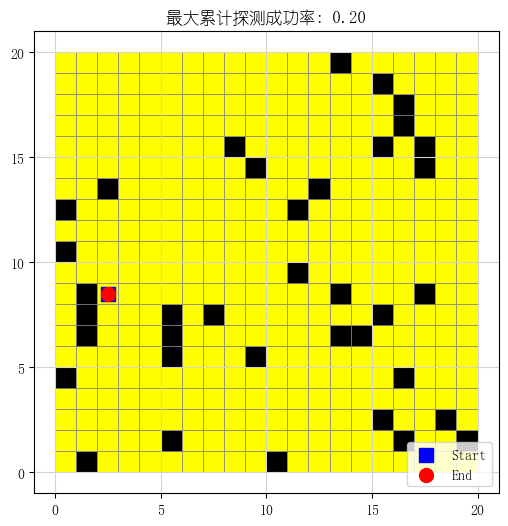

In [ ]:
#强化学习均匀分布
"""
强化学习Q-Learning算法在【单智能体静态环境下】搜索路径规划的仿真环境 - 多场景可配置版
功能：支持切换障碍物类型、POC分布类型、目标位置等场景
作者：HHH
版本：v1.0
日期：2025.3.16
"""

import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import datetime


class Environment:
	def __init__(self,
				 grid_size=20,
				 pod=1.0,
				 poc_type='gaussian',  # 可选项: 'gaussian','uniform','01'
				 obstacle_type='fixed',  # 可选项: 'fixed','random'
				 start_pos = (0, 0),  # 搜索的起始位置
				 target_pos_01 = (19, 19),  # 01分布中“1”分布的位置（目标位置）
				 theta=0,  # 高斯分布阈值
				 sigma=5.0,  # 高斯分布标准差
				 gauss_center=None,  # 高斯分布中心(None时为网格中心)
				 obstacle_density=0.1,  # 随机障碍物密度
				 max_steps=10000):

		# 环境参数初始化
		self.grid_size = grid_size
		self.pod = pod
		self.theta = theta
		self.poc_type = poc_type
		self.obstacle_type = obstacle_type
		self.target_pos_01 = target_pos_01
		self.start_pos = start_pos
		self.sigma = sigma
		self.gauss_center = gauss_center if gauss_center else (grid_size // 2, grid_size // 2)
		self.obstacle_density = obstacle_density
		self.max_steps = max_steps

		# 环境状态初始化
		self.obstacles = np.zeros((grid_size, grid_size), dtype=int)
		self.poc = np.zeros((grid_size, grid_size))
		self.searched = np.zeros((grid_size, grid_size), dtype=int)
		self.searched_final = np.zeros((grid_size, grid_size), dtype=int)
		self.state_grid = np.zeros((grid_size, grid_size), dtype=int)
		self.dirs = [(-1, 0), (-1, 1), (0, 1), (1, 1),
					 (1, 0), (1, -1), (0, -1), (-1, -1)]  # 8个方向动作

		# 动态组件初始化
		self.current_step = 0
		self.agent_pos = None
		self.history_max_pos_cum = 0
		self.pos_cum = 0

		# 调用初始化方法
		self.initialize_obstacles()
		self.initialize_poc()
		self.determine_low_value_regions()

	def initialize_obstacles(self):
		"""障碍物初始化"""
		if self.obstacle_type == 'fixed':
			self.initialize_fixed_obstacles()
		elif self.obstacle_type == 'random':
			self.initialize_random_obstacles()
		self.state_grid = np.copy(self.obstacles)

	def initialize_fixed_obstacles(self):
		"""固定障碍物配置"""
		fixed_obstacles = [
			(0, 4), (0, 10), (0, 12), (1, 0), (1, 6), (1, 7), (1, 8), (2, 13),
			(5, 1), (5, 5), (5, 6), (5, 7), (7, 7), (8, 15), (9, 5), (9, 14),
			(10, 0), (11, 9), (11, 12), (12, 13), (13, 6), (13, 8), (13, 19),
			(14, 6), (15, 2), (15, 7), (15, 15), (15, 18), (16, 1), (16, 4), (16, 16), (16, 17),
			(17, 8), (17, 14), (17, 15), (18, 2), (17, 8), (19, 1)
		]
		for x, y in fixed_obstacles:
			if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
				self.obstacles[x, y] = -2

	def initialize_random_obstacles(self):
		"""随机障碍物生成"""
		num_obstacles = int(self.obstacle_density * self.grid_size ** 2)
		indices = np.random.choice(self.grid_size ** 2, num_obstacles, replace=False)
		for idx in indices:
			x, y = idx // self.grid_size, idx % self.grid_size
			self.obstacles[x, y] = -2
		# 确保起点无障碍
		self.obstacles[env.start_pos] = 0

	def initialize_poc(self):
		"""POC分布初始化"""
		if self.poc_type == 'gaussian':
			self.initialize_gauss_poc()
		elif self.poc_type == 'uniform':
			self.initialize_uniform_poc()
		elif self.poc_type == '01':
			self.initialize_01_poc()

	def initialize_gauss_poc(self):
		"""高斯分布POC"""
		x = np.arange(0, self.grid_size)
		y = np.arange(0, self.grid_size)
		X, Y = np.meshgrid(x, y)
		exponent = ((X - self.gauss_center[1]) ** 2 +
					(Y - self.gauss_center[0]) ** 2) / (2 * self.sigma ** 2)
		self.poc = np.exp(-exponent)
		self.poc = (self.poc - self.poc.min()) / (self.poc.max() - self.poc.min())

	def initialize_uniform_poc(self):
		"""均匀分布POC"""
		uniform_value = 1 / (self.grid_size ** 2) * 100
		self.poc = np.full((self.grid_size, self.grid_size), uniform_value)

	def initialize_01_poc(self):
		"""01分布POC"""
		self.poc = np.zeros((self.grid_size, self.grid_size))
		if 0 <= self.target_pos_01[0] < self.grid_size and 0 <= self.target_pos_01[1] < self.grid_size:
			self.poc[self.target_pos_01] = 1

	def determine_low_value_regions(self):
		"""确定低价值区域"""
		low_value_mask = (self.poc < self.theta) & (self.state_grid != -2)
		self.state_grid[low_value_mask] = -1

	def update_searched_final(self):
		"""全局更新已探索过的区域"""
		for x in range(self.grid_size):
			for y in range(self.grid_size):
				if self.searched[x, y] == 1:
					self.searched_final[x, y] = 1

	def reset(self):
		"""环境重置"""
		self.searched.fill(0)
		self.current_step = 0
		self.agent_pos = self.start_pos  # 重置起点
		self.pos_cum = 0
		self.determine_low_value_regions()
		return self.agent_pos

	def get_pos(self, x, y):
		"""获取当前位置的探测概率"""
		return 0 if self.state_grid[x, y] == -2 else self.poc[x, y] * self.pod

	def step(self, action):
		"""执行动作"""
		dx, dy = self.dirs[action]
		x, y = self.agent_pos
		new_x, new_y = x + dx, y + dy

		# 碰撞检测。若移动到边界之外或障碍物，保持原位
		if not (0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size) \
				or self.state_grid[new_x, new_y] == -2:
			new_x, new_y = x, y

		# 更新智能体位置并获取POC值
		self.agent_pos = (new_x, new_y)
		pos = self.get_pos(new_x, new_y)

		# 更新累计探测概率（移动平均）
		pos_cum_prev = self.pos_cum
		self.pos_cum = (pos_cum_prev * self.current_step + pos) / (self.current_step + 1)

		# 奖励计算
		reward_step, reward_cumulative, reward_target, done = self._calculate_rewards(new_x, new_y, pos)

		# 总奖励加权计算
		a = 0.3; b = 0.3; c = 0.4
		reward_total = a * reward_step + b * reward_cumulative + c * reward_target
		self.current_step += 1

		return self.agent_pos, reward_total, done

	def _calculate_rewards(self, new_x, new_y, pos):
		"""奖励函数设计"""
		"""即时奖励"""
		if self.searched[new_x, new_y] == 0:  # 若之前没有被探测过
			self.searched[new_x, new_y] = 1
			# 当前网格状态若不是-1(低价值区域）也不是-2（障碍物）的话，就设置为1（初始默认为0），否则不变（依然还是-1或还是-2）
			self.state_grid[new_x, new_y] = 1 if self.state_grid[new_x, new_y] not in (-1, -2) else self.state_grid[new_x, new_y]

			if self.state_grid[new_x, new_y] == -2:  # 若为障碍物
				reward_step = -10000
			elif self.state_grid[new_x, new_y] == -1:  # 若为低价值区域
				reward_step = -0.5
			elif self.state_grid[new_x, new_y] == 1:  # 若为高价值区域
				reward_step = pos * 100
		else:  # 若之前被探测过
			if self.state_grid[new_x, new_y] == -2:  # 若为障碍物
				reward_step = -10000
			elif self.state_grid[new_x, new_y] == -1:  # 若为低价值区域
				reward_step = -0.5
			elif self.state_grid[new_x, new_y] == 1:  # 若为高价值区域
				reward_step = pos * 100

		"""探测概率奖励"""
		reward_cumulative = 1000 if self.pos_cum > self.history_max_pos_cum else 0
		if self.pos_cum > self.history_max_pos_cum:
			self.history_max_pos_cum = self.pos_cum

		"""回合奖励"""
		if self.current_step >= self.max_steps:
			reward_target = -100
			done = True
		elif self.searched.sum() == self.grid_size ** 2:
			reward_target = 10000
			done = True
		else:
			reward_target = 0
			done = False

		return reward_step, reward_cumulative, reward_target, done


class QLearningAgent:
	def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.2):
		self.env = env
		self.alpha = alpha
		self.gamma = gamma
		self.epsilon = epsilon
		self.q_table = np.zeros((env.grid_size, env.grid_size, 8))

	def choose_action(self, state):
		x, y = state
		# np.random.rand()生成[0,1)的随机数，若小于epsilon则触发探索（返回0-7的随机整数作为动作）；
		# 否则返回Q表中(x,y)状态下最大值对应的动作
		if np.random.rand() < self.epsilon:
			return np.random.choice(8)
		else:
			return np.argmax(self.q_table[x, y, :])

	def update_q_table(self, state, action, reward, next_state):
		x, y = state
		nx, ny = next_state
		current_q = self.q_table[x, y, action]
		max_next_q = np.max(self.q_table[nx, ny, :])
		self.q_table[x, y, action] += self.alpha * (reward + self.gamma * max_next_q - current_q)


def train(episodes,  **env_kwargs):
	"""训练函数"""
	env = Environment(**env_kwargs)
	agent = QLearningAgent(env)

	print(f"训练开始: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
	start_time = time.time()

	for episode in range(episodes):
		# agent.epsilon = 0.9 * (1 - episode / episodes)  #epsilon线性衰减，前期充分探索，后期侧重利用
		state = env.reset()
		done = False

		while not done:
			action = agent.choose_action(state)
			next_state, reward, done = env.step(action)
			agent.update_q_table(state, action, reward, next_state)
			state = next_state

		env.update_searched_final()  # 每次episode结束后更新已探测过的区域到searched_final中（全程记录已探索过的区域）
		if episode % 100 == 0:
			print(f"Episode {episode} | 当前累计POS: {env.pos_cum:.2f} | 历史最大POS: {env.history_max_pos_cum:.2f}")

	print(f"训练耗时: {time.time() - start_time:.1f}秒")
	return agent, env


def visualize(env, agent):
	"""可视化函数"""
	plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
	plt.rcParams['axes.unicode_minus'] = False
	plt.figure(figsize=(6, 6))

	# 绘制网格
	for x in range(env.grid_size):
		for y in range(env.grid_size):
			color = 'black' if env.obstacles[x, y] == -2 else \
				'yellow' if env.state_grid[x, y] == -1 else \
					'green' if env.searched_final[x, y] == 1 else 'white'
			plt.fill_between([x, x + 1], y, y + 1, color=color, edgecolor='gray', linewidth=0.5)

	# 生成路径
	state = env.reset()
	path = [state]
	visited = set()

	for _ in range(env.max_steps):
		x, y = state
		action = np.argmax(agent.q_table[x, y, :])
		dx, dy = env.dirs[action]
		new_x = x + dx
		new_y = y + dy

		# 检查移动是否有效
		if (0 <= new_x < env.grid_size and 0 <= new_y < env.grid_size) \
				and env.state_grid[new_x, new_y] != -2:
			state = (new_x, new_y)

		# 避免重复路径
		if state in visited:
			break

		visited.add(state)
		path.append(state)

	# 绘制路径
	x_coords = [x + 0.5 for (x, y) in path]  # 列y -> matplotlib的x轴
	y_coords = [y + 0.5 for (x, y) in path]  # 行x -> matplotlib的y轴（左下原点，y向上增长）
	plt.plot(x_coords, y_coords, 'r-', lw=2, alpha=0.7)

	# 标记起点和终点
	plt.scatter(x_coords[0], y_coords[0], c='blue', marker='s', s=100, label='Start')
	plt.scatter(x_coords[-1], y_coords[-1], c='red', marker='o', s=100, label='End')

	# 标记目标点
	if env.poc_type == '01':
		object_x, object_y = np.where(env.poc == 1)
		plt.scatter([obj_x + 0.5 for obj_x in object_x],
					[obj_y + 0.5 for obj_y in object_y],
					c='purple', marker='*', s=100, label='Target')
	elif env.poc_type == 'gaussian':
		plt.scatter(env.gauss_center[0] + 0.5, env.gauss_center[1] + 0.5,
					c='purple', marker='*', s=100, label='Gaussian Center')

	# 坐标轴设置
	plt.xticks(np.arange(0, env.grid_size + 1, 5))  # x轴刻度
	plt.yticks(np.arange(0, env.grid_size + 1, 5))  # y轴刻度（自然增长，无需翻转）
	plt.grid(color='lightgray')
	plt.title(f"最大累计探测成功率: {env.history_max_pos_cum:.2f}")
	plt.legend()#图例位置loc='upper right'/'lower left'/'center'/'best'，默认upper right
	plt.show()

if __name__ == "__main__":
	# 场景配置示例
	config = {
		'grid_size': 20,  # 网格大小
		'pod': 0.8,  # POD值，POD∈[0,1]
		'poc_type': 'uniform',  # 可选'gaussian'或'01'或'uniform'
		'obstacle_type': 'fixed',  # 可选'fixed'或'random'
		'start_pos': (2, 8),  # 搜索起始位置
		'target_pos_01': (1, 19),  # 01分布中“1”分布的位置（目标位置）
		'theta': 0,  # 高斯分布低价值区域阈值，不使用高斯分布时请设为0
		'sigma': 5.0,  # 高斯分布标准差
		'gauss_center': (16,6),  # 高斯分布中心'None'或'(x,y)'
		'obstacle_density': 0.1,  # 随机障碍物密度
		'max_steps': 10000,  # 最大步数
	}

	agent, env = train(episodes=1000, **config)
	visualize(env, agent)

In [ ]:
#强化学习0-1分布
"""
强化学习Q-Learning算法在【单智能体静态环境下】搜索路径规划的仿真环境 - 多场景可配置版
功能：支持切换障碍物类型、POC分布类型、目标位置等场景
作者：HHH
版本：v1.0
日期：2025.3.16
"""

import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import datetime


class Environment:
	def __init__(self,
				 grid_size=20,
				 pod=1.0,
				 poc_type='gaussian',  # 可选项: 'gaussian','uniform','01'
				 obstacle_type='fixed',  # 可选项: 'fixed','random'
				 start_pos = (0, 0),  # 搜索的起始位置
				 target_pos_01 = (19, 19),  # 01分布中“1”分布的位置（目标位置）
				 theta=0,  # 高斯分布阈值
				 sigma=5.0,  # 高斯分布标准差
				 gauss_center=None,  # 高斯分布中心(None时为网格中心)
				 obstacle_density=0.1,  # 随机障碍物密度
				 max_steps=10000):

		# 环境参数初始化
		self.grid_size = grid_size
		self.pod = pod
		self.theta = theta
		self.poc_type = poc_type
		self.obstacle_type = obstacle_type
		self.target_pos_01 = target_pos_01
		self.start_pos = start_pos
		self.sigma = sigma
		self.gauss_center = gauss_center if gauss_center else (grid_size // 2, grid_size // 2)
		self.obstacle_density = obstacle_density
		self.max_steps = max_steps

		# 环境状态初始化
		self.obstacles = np.zeros((grid_size, grid_size), dtype=int)
		self.poc = np.zeros((grid_size, grid_size))
		self.searched = np.zeros((grid_size, grid_size), dtype=int)
		self.searched_final = np.zeros((grid_size, grid_size), dtype=int)
		self.state_grid = np.zeros((grid_size, grid_size), dtype=int)
		self.dirs = [(-1, 0), (-1, 1), (0, 1), (1, 1),
					 (1, 0), (1, -1), (0, -1), (-1, -1)]  # 8个方向动作

		# 动态组件初始化
		self.current_step = 0
		self.agent_pos = None
		self.history_max_pos_cum = 0
		self.pos_cum = 0

		# 调用初始化方法
		self.initialize_obstacles()
		self.initialize_poc()
		self.determine_low_value_regions()

	def initialize_obstacles(self):
		"""障碍物初始化"""
		if self.obstacle_type == 'fixed':
			self.initialize_fixed_obstacles()
		elif self.obstacle_type == 'random':
			self.initialize_random_obstacles()
		self.state_grid = np.copy(self.obstacles)

	def initialize_fixed_obstacles(self):
		"""固定障碍物配置"""
		fixed_obstacles = [
			(0, 4), (0, 10), (0, 12), (1, 0), (1, 6), (1, 7), (1, 8), (2, 13),
			(5, 1), (5, 5), (5, 6), (5, 7), (7, 7), (8, 15), (9, 5), (9, 14),
			(10, 0), (11, 9), (11, 12), (12, 13), (13, 6), (13, 8), (13, 19),
			(14, 6), (15, 2), (15, 7), (15, 15), (15, 18), (16, 1), (16, 4), (16, 16), (16, 17),
			(17, 8), (17, 14), (17, 15), (18, 2), (17, 8), (19, 1)
		]
		for x, y in fixed_obstacles:
			if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
				self.obstacles[x, y] = -2

	def initialize_random_obstacles(self):
		"""随机障碍物生成"""
		num_obstacles = int(self.obstacle_density * self.grid_size ** 2)
		indices = np.random.choice(self.grid_size ** 2, num_obstacles, replace=False)
		for idx in indices:
			x, y = idx // self.grid_size, idx % self.grid_size
			self.obstacles[x, y] = -2
		# 确保起点无障碍
		self.obstacles[env.start_pos] = 0

	def initialize_poc(self):
		"""POC分布初始化"""
		if self.poc_type == 'gaussian':
			self.initialize_gauss_poc()
		elif self.poc_type == 'uniform':
			self.initialize_uniform_poc()
		elif self.poc_type == '01':
			self.initialize_01_poc()

	def initialize_gauss_poc(self):
		"""高斯分布POC"""
		x = np.arange(0, self.grid_size)
		y = np.arange(0, self.grid_size)
		X, Y = np.meshgrid(x, y)
		exponent = ((X - self.gauss_center[1]) ** 2 +
					(Y - self.gauss_center[0]) ** 2) / (2 * self.sigma ** 2)
		self.poc = np.exp(-exponent)
		self.poc = (self.poc - self.poc.min()) / (self.poc.max() - self.poc.min())

	def initialize_uniform_poc(self):
		"""均匀分布POC"""
		uniform_value = 1 / (self.grid_size ** 2) * 100
		self.poc = np.full((self.grid_size, self.grid_size), uniform_value)

	def initialize_01_poc(self):
		"""01分布POC"""
		self.poc = np.zeros((self.grid_size, self.grid_size))
		if 0 <= self.target_pos_01[0] < self.grid_size and 0 <= self.target_pos_01[1] < self.grid_size:
			self.poc[self.target_pos_01] = 1

	def determine_low_value_regions(self):
		"""确定低价值区域"""
		low_value_mask = (self.poc < self.theta) & (self.state_grid != -2)
		self.state_grid[low_value_mask] = -1

	def update_searched_final(self):
		"""全局更新已探索过的区域"""
		for x in range(self.grid_size):
			for y in range(self.grid_size):
				if self.searched[x, y] == 1:
					self.searched_final[x, y] = 1

	def reset(self):
		"""环境重置"""
		self.searched.fill(0)
		self.current_step = 0
		self.agent_pos = self.start_pos  # 重置起点
		self.pos_cum = 0
		self.determine_low_value_regions()
		return self.agent_pos

	def get_pos(self, x, y):
		"""获取当前位置的探测概率"""
		return 0 if self.state_grid[x, y] == -2 else self.poc[x, y] * self.pod

	def step(self, action):
		"""执行动作"""
		dx, dy = self.dirs[action]
		x, y = self.agent_pos
		new_x, new_y = x + dx, y + dy

		# 碰撞检测。若移动到边界之外或障碍物，保持原位
		if not (0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size) \
				or self.state_grid[new_x, new_y] == -2:
			new_x, new_y = x, y

		# 更新智能体位置并获取POC值
		self.agent_pos = (new_x, new_y)
		pos = self.get_pos(new_x, new_y)

		# 更新累计探测概率（移动平均）
		pos_cum_prev = self.pos_cum
		self.pos_cum = (pos_cum_prev * self.current_step + pos) / (self.current_step + 1)

		# 奖励计算
		reward_step, reward_cumulative, reward_target, done = self._calculate_rewards(new_x, new_y, pos)

		# 总奖励加权计算
		a = 0.3; b = 0.3; c = 0.4
		reward_total = a * reward_step + b * reward_cumulative + c * reward_target
		self.current_step += 1

		return self.agent_pos, reward_total, done

	def _calculate_rewards(self, new_x, new_y, pos):
		"""奖励函数设计"""
		"""即时奖励"""
		if self.searched[new_x, new_y] == 0:  # 若之前没有被探测过
			self.searched[new_x, new_y] = 1
			# 当前网格状态若不是-1(低价值区域）也不是-2（障碍物）的话，就设置为1（初始默认为0），否则不变（依然还是-1或还是-2）
			self.state_grid[new_x, new_y] = 1 if self.state_grid[new_x, new_y] not in (-1, -2) else self.state_grid[new_x, new_y]

			if self.state_grid[new_x, new_y] == -2:  # 若为障碍物
				reward_step = -10000
			elif self.state_grid[new_x, new_y] == -1:  # 若为低价值区域
				reward_step = -0.5
			elif self.state_grid[new_x, new_y] == 1:  # 若为高价值区域
				reward_step = pos * 100
		else:  # 若之前被探测过
			if self.state_grid[new_x, new_y] == -2:  # 若为障碍物
				reward_step = -10000
			elif self.state_grid[new_x, new_y] == -1:  # 若为低价值区域
				reward_step = -0.5
			elif self.state_grid[new_x, new_y] == 1:  # 若为高价值区域
				reward_step = pos * 100

		"""探测概率奖励"""
		reward_cumulative = 1000 if self.pos_cum > self.history_max_pos_cum else 0
		if self.pos_cum > self.history_max_pos_cum:
			self.history_max_pos_cum = self.pos_cum

		"""回合奖励"""
		if self.current_step >= self.max_steps:
			reward_target = -100
			done = True
		elif self.searched.sum() == self.grid_size ** 2:
			reward_target = 10000
			done = True
		else:
			reward_target = 0
			done = False

		return reward_step, reward_cumulative, reward_target, done


class QLearningAgent:
	def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.2):
		self.env = env
		self.alpha = alpha
		self.gamma = gamma
		self.epsilon = epsilon
		self.q_table = np.zeros((env.grid_size, env.grid_size, 8))

	def choose_action(self, state):
		x, y = state
		# np.random.rand()生成[0,1)的随机数，若小于epsilon则触发探索（返回0-7的随机整数作为动作）；
		# 否则返回Q表中(x,y)状态下最大值对应的动作
		if np.random.rand() < self.epsilon:
			return np.random.choice(8)
		else:
			return np.argmax(self.q_table[x, y, :])

	def update_q_table(self, state, action, reward, next_state):
		x, y = state
		nx, ny = next_state
		current_q = self.q_table[x, y, action]
		max_next_q = np.max(self.q_table[nx, ny, :])
		self.q_table[x, y, action] += self.alpha * (reward + self.gamma * max_next_q - current_q)


def train(episodes,  **env_kwargs):
	"""训练函数"""
	env = Environment(**env_kwargs)
	agent = QLearningAgent(env)

	print(f"训练开始: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
	start_time = time.time()

	for episode in range(episodes):
		# agent.epsilon = 0.9 * (1 - episode / episodes)  #epsilon线性衰减，前期充分探索，后期侧重利用
		state = env.reset()
		done = False

		while not done:
			action = agent.choose_action(state)
			next_state, reward, done = env.step(action)
			agent.update_q_table(state, action, reward, next_state)
			state = next_state

		env.update_searched_final()  # 每次episode结束后更新已探测过的区域到searched_final中（全程记录已探索过的区域）
		if episode % 100 == 0:
			print(f"Episode {episode} | 当前累计POS: {env.pos_cum:.2f} | 历史最大POS: {env.history_max_pos_cum:.2f}")

	print(f"训练耗时: {time.time() - start_time:.1f}秒")
	return agent, env


def visualize(env, agent):
	"""可视化函数"""
	plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
	plt.rcParams['axes.unicode_minus'] = False
	plt.figure(figsize=(6, 6))

	# 绘制网格
	for x in range(env.grid_size):
		for y in range(env.grid_size):
			color = 'black' if env.obstacles[x, y] == -2 else \
				'yellow' if env.state_grid[x, y] == -1 else \
					'green' if env.searched_final[x, y] == 1 else 'white'
			plt.fill_between([x, x + 1], y, y + 1, color=color, edgecolor='gray', linewidth=0.5)

	# 生成路径
	state = env.reset()
	path = [state]
	visited = set()

	for _ in range(env.max_steps):
		x, y = state
		action = np.argmax(agent.q_table[x, y, :])
		dx, dy = env.dirs[action]
		new_x = x + dx
		new_y = y + dy

		# 检查移动是否有效
		if (0 <= new_x < env.grid_size and 0 <= new_y < env.grid_size) \
				and env.state_grid[new_x, new_y] != -2:
			state = (new_x, new_y)

		# 避免重复路径
		if state in visited:
			break

		visited.add(state)
		path.append(state)

	# 绘制路径
	x_coords = [x + 0.5 for (x, y) in path]  # 列y -> matplotlib的x轴
	y_coords = [y + 0.5 for (x, y) in path]  # 行x -> matplotlib的y轴（左下原点，y向上增长）
	plt.plot(x_coords, y_coords, 'r-', lw=2, alpha=0.7)

	# 标记起点和终点
	plt.scatter(x_coords[0], y_coords[0], c='blue', marker='s', s=100, label='Start')
	plt.scatter(x_coords[-1], y_coords[-1], c='red', marker='o', s=100, label='End')

	# 标记目标点
	if env.poc_type == '01':
		object_x, object_y = np.where(env.poc == 1)
		plt.scatter([obj_x + 0.5 for obj_x in object_x],
					[obj_y + 0.5 for obj_y in object_y],
					c='purple', marker='*', s=100, label='Target')
	elif env.poc_type == 'gaussian':
		plt.scatter(env.gauss_center[0] + 0.5, env.gauss_center[1] + 0.5,
					c='purple', marker='*', s=100, label='Gaussian Center')

	# 坐标轴设置
	plt.xticks(np.arange(0, env.grid_size + 1, 5))  # x轴刻度
	plt.yticks(np.arange(0, env.grid_size + 1, 5))  # y轴刻度（自然增长，无需翻转）
	plt.grid(color='lightgray')
	plt.title(f"最大累计探测成功率: {env.history_max_pos_cum:.2f}")
	plt.legend()#图例位置loc='upper right'/'lower left'/'center'/'best'，默认upper right
	plt.show()

if __name__ == "__main__":
	# 场景配置示例
	config = {
		'grid_size': 20,  # 网格大小
		'pod': 0.8,  # POD值，POD∈[0,1]
		'poc_type': '01',  # 可选'gaussian'或'01'或'uniform'
		'obstacle_type': 'fixed',  # 可选'fixed'或'random'
		'start_pos': (2, 8),  # 搜索起始位置
		'target_pos_01': (1, 19),  # 01分布中“1”分布的位置（目标位置）
		'theta': 0,  # 高斯分布低价值区域阈值，不使用高斯分布时请设为0
		'sigma': 5.0,  # 高斯分布标准差
		'gauss_center': (16,6),  # 高斯分布中心'None'或'(x,y)'
		'obstacle_density': 0.1,  # 随机障碍物密度
		'max_steps': 10000,  # 最大步数
	}

	agent, env = train(episodes=1000, **config)
	visualize(env, agent)

In [ ]:
#强化学习高斯分布
"""
强化学习Q-Learning算法在【单智能体静态环境下】搜索路径规划的仿真环境 - 多场景可配置版
功能：支持切换障碍物类型、POC分布类型、目标位置等场景
作者：HHH
版本：v1.0
日期：2025.3.16
"""

import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import datetime


class Environment:
	def __init__(self,
				 grid_size=20,
				 pod=1.0,
				 poc_type='gaussian',  # 可选项: 'gaussian','uniform','01'
				 obstacle_type='fixed',  # 可选项: 'fixed','random'
				 start_pos = (0, 0),  # 搜索的起始位置
				 target_pos_01 = (19, 19),  # 01分布中“1”分布的位置（目标位置）
				 theta=0,  # 高斯分布阈值
				 sigma=5.0,  # 高斯分布标准差
				 gauss_center=None,  # 高斯分布中心(None时为网格中心)
				 obstacle_density=0.1,  # 随机障碍物密度
				 max_steps=10000):

		# 环境参数初始化
		self.grid_size = grid_size
		self.pod = pod
		self.theta = theta
		self.poc_type = poc_type
		self.obstacle_type = obstacle_type
		self.target_pos_01 = target_pos_01
		self.start_pos = start_pos
		self.sigma = sigma
		self.gauss_center = gauss_center if gauss_center else (grid_size // 2, grid_size // 2)
		self.obstacle_density = obstacle_density
		self.max_steps = max_steps

		# 环境状态初始化
		self.obstacles = np.zeros((grid_size, grid_size), dtype=int)
		self.poc = np.zeros((grid_size, grid_size))
		self.searched = np.zeros((grid_size, grid_size), dtype=int)
		self.searched_final = np.zeros((grid_size, grid_size), dtype=int)
		self.state_grid = np.zeros((grid_size, grid_size), dtype=int)
		self.dirs = [(-1, 0), (-1, 1), (0, 1), (1, 1),
					 (1, 0), (1, -1), (0, -1), (-1, -1)]  # 8个方向动作

		# 动态组件初始化
		self.current_step = 0
		self.agent_pos = None
		self.history_max_pos_cum = 0
		self.pos_cum = 0

		# 调用初始化方法
		self.initialize_obstacles()
		self.initialize_poc()
		self.determine_low_value_regions()

	def initialize_obstacles(self):
		"""障碍物初始化"""
		if self.obstacle_type == 'fixed':
			self.initialize_fixed_obstacles()
		elif self.obstacle_type == 'random':
			self.initialize_random_obstacles()
		self.state_grid = np.copy(self.obstacles)

	def initialize_fixed_obstacles(self):
		"""固定障碍物配置"""
		fixed_obstacles = [
			(0, 4), (0, 10), (0, 12), (1, 0), (1, 6), (1, 7), (1, 8), (2, 13),
			(5, 1), (5, 5), (5, 6), (5, 7), (7, 7), (8, 15), (9, 5), (9, 14),
			(10, 0), (11, 9), (11, 12), (12, 13), (13, 6), (13, 8), (13, 19),
			(14, 6), (15, 2), (15, 7), (15, 15), (15, 18), (16, 1), (16, 4), (16, 16), (16, 17),
			(17, 8), (17, 14), (17, 15), (18, 2), (17, 8), (19, 1)
		]
		for x, y in fixed_obstacles:
			if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
				self.obstacles[x, y] = -2

	def initialize_random_obstacles(self):
		"""随机障碍物生成"""
		num_obstacles = int(self.obstacle_density * self.grid_size ** 2)
		indices = np.random.choice(self.grid_size ** 2, num_obstacles, replace=False)
		for idx in indices:
			x, y = idx // self.grid_size, idx % self.grid_size
			self.obstacles[x, y] = -2
		# 确保起点无障碍
		self.obstacles[env.start_pos] = 0

	def initialize_poc(self):
		"""POC分布初始化"""
		if self.poc_type == 'gaussian':
			self.initialize_gauss_poc()
		elif self.poc_type == 'uniform':
			self.initialize_uniform_poc()
		elif self.poc_type == '01':
			self.initialize_01_poc()

	def initialize_gauss_poc(self):
		"""高斯分布POC"""
		x = np.arange(0, self.grid_size)
		y = np.arange(0, self.grid_size)
		X, Y = np.meshgrid(x, y)
		exponent = ((X - self.gauss_center[1]) ** 2 +
					(Y - self.gauss_center[0]) ** 2) / (2 * self.sigma ** 2)
		self.poc = np.exp(-exponent)
		self.poc = (self.poc - self.poc.min()) / (self.poc.max() - self.poc.min())

	def initialize_uniform_poc(self):
		"""均匀分布POC"""
		uniform_value = 1 / (self.grid_size ** 2) * 100
		self.poc = np.full((self.grid_size, self.grid_size), uniform_value)

	def initialize_01_poc(self):
		"""01分布POC"""
		self.poc = np.zeros((self.grid_size, self.grid_size))
		if 0 <= self.target_pos_01[0] < self.grid_size and 0 <= self.target_pos_01[1] < self.grid_size:
			self.poc[self.target_pos_01] = 1

	def determine_low_value_regions(self):
		"""确定低价值区域"""
		low_value_mask = (self.poc < self.theta) & (self.state_grid != -2)
		self.state_grid[low_value_mask] = -1

	def update_searched_final(self):
		"""全局更新已探索过的区域"""
		for x in range(self.grid_size):
			for y in range(self.grid_size):
				if self.searched[x, y] == 1:
					self.searched_final[x, y] = 1

	def reset(self):
		"""环境重置"""
		self.searched.fill(0)
		self.current_step = 0
		self.agent_pos = self.start_pos  # 重置起点
		self.pos_cum = 0
		self.determine_low_value_regions()
		return self.agent_pos

	def get_pos(self, x, y):
		"""获取当前位置的探测概率"""
		return 0 if self.state_grid[x, y] == -2 else self.poc[x, y] * self.pod

	def step(self, action):
		"""执行动作"""
		dx, dy = self.dirs[action]
		x, y = self.agent_pos
		new_x, new_y = x + dx, y + dy

		# 碰撞检测。若移动到边界之外或障碍物，保持原位
		if not (0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size) \
				or self.state_grid[new_x, new_y] == -2:
			new_x, new_y = x, y

		# 更新智能体位置并获取POC值
		self.agent_pos = (new_x, new_y)
		pos = self.get_pos(new_x, new_y)

		# 更新累计探测概率（移动平均）
		pos_cum_prev = self.pos_cum
		self.pos_cum = (pos_cum_prev * self.current_step + pos) / (self.current_step + 1)

		# 奖励计算
		reward_step, reward_cumulative, reward_target, done = self._calculate_rewards(new_x, new_y, pos)

		# 总奖励加权计算
		a = 0.3; b = 0.3; c = 0.4
		reward_total = a * reward_step + b * reward_cumulative + c * reward_target
		self.current_step += 1

		return self.agent_pos, reward_total, done

	def _calculate_rewards(self, new_x, new_y, pos):
		"""奖励函数设计"""
		"""即时奖励"""
		if self.searched[new_x, new_y] == 0:  # 若之前没有被探测过
			self.searched[new_x, new_y] = 1
			# 当前网格状态若不是-1(低价值区域）也不是-2（障碍物）的话，就设置为1（初始默认为0），否则不变（依然还是-1或还是-2）
			self.state_grid[new_x, new_y] = 1 if self.state_grid[new_x, new_y] not in (-1, -2) else self.state_grid[new_x, new_y]

			if self.state_grid[new_x, new_y] == -2:  # 若为障碍物
				reward_step = -10000
			elif self.state_grid[new_x, new_y] == -1:  # 若为低价值区域
				reward_step = -0.5
			elif self.state_grid[new_x, new_y] == 1:  # 若为高价值区域
				reward_step = pos * 100
		else:  # 若之前被探测过
			if self.state_grid[new_x, new_y] == -2:  # 若为障碍物
				reward_step = -10000
			elif self.state_grid[new_x, new_y] == -1:  # 若为低价值区域
				reward_step = -0.5
			elif self.state_grid[new_x, new_y] == 1:  # 若为高价值区域
				reward_step = pos * 100

		"""探测概率奖励"""
		reward_cumulative = 1000 if self.pos_cum > self.history_max_pos_cum else 0
		if self.pos_cum > self.history_max_pos_cum:
			self.history_max_pos_cum = self.pos_cum

		"""回合奖励"""
		if self.current_step >= self.max_steps:
			reward_target = -100
			done = True
		elif self.searched.sum() == self.grid_size ** 2:
			reward_target = 10000
			done = True
		else:
			reward_target = 0
			done = False

		return reward_step, reward_cumulative, reward_target, done


class QLearningAgent:
	def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.2):
		self.env = env
		self.alpha = alpha
		self.gamma = gamma
		self.epsilon = epsilon
		self.q_table = np.zeros((env.grid_size, env.grid_size, 8))

	def choose_action(self, state):
		x, y = state
		# np.random.rand()生成[0,1)的随机数，若小于epsilon则触发探索（返回0-7的随机整数作为动作）；
		# 否则返回Q表中(x,y)状态下最大值对应的动作
		if np.random.rand() < self.epsilon:
			return np.random.choice(8)
		else:
			return np.argmax(self.q_table[x, y, :])

	def update_q_table(self, state, action, reward, next_state):
		x, y = state
		nx, ny = next_state
		current_q = self.q_table[x, y, action]
		max_next_q = np.max(self.q_table[nx, ny, :])
		self.q_table[x, y, action] += self.alpha * (reward + self.gamma * max_next_q - current_q)


def train(episodes,  **env_kwargs):
	"""训练函数"""
	env = Environment(**env_kwargs)
	agent = QLearningAgent(env)

	print(f"训练开始: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
	start_time = time.time()

	for episode in range(episodes):
		# agent.epsilon = 0.9 * (1 - episode / episodes)  #epsilon线性衰减，前期充分探索，后期侧重利用
		state = env.reset()
		done = False

		while not done:
			action = agent.choose_action(state)
			next_state, reward, done = env.step(action)
			agent.update_q_table(state, action, reward, next_state)
			state = next_state

		env.update_searched_final()  # 每次episode结束后更新已探测过的区域到searched_final中（全程记录已探索过的区域）
		if episode % 100 == 0:
			print(f"Episode {episode} | 当前累计POS: {env.pos_cum:.2f} | 历史最大POS: {env.history_max_pos_cum:.2f}")

	print(f"训练耗时: {time.time() - start_time:.1f}秒")
	return agent, env


def visualize(env, agent):
	"""可视化函数"""
	plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
	plt.rcParams['axes.unicode_minus'] = False
	plt.figure(figsize=(6, 6))

	# 绘制网格
	for x in range(env.grid_size):
		for y in range(env.grid_size):
			color = 'black' if env.obstacles[x, y] == -2 else \
				'yellow' if env.state_grid[x, y] == -1 else \
					'green' if env.searched_final[x, y] == 1 else 'white'
			plt.fill_between([x, x + 1], y, y + 1, color=color, edgecolor='gray', linewidth=0.5)

	# 生成路径
	state = env.reset()
	path = [state]
	visited = set()

	for _ in range(env.max_steps):
		x, y = state
		action = np.argmax(agent.q_table[x, y, :])
		dx, dy = env.dirs[action]
		new_x = x + dx
		new_y = y + dy

		# 检查移动是否有效
		if (0 <= new_x < env.grid_size and 0 <= new_y < env.grid_size) \
				and env.state_grid[new_x, new_y] != -2:
			state = (new_x, new_y)

		# 避免重复路径
		if state in visited:
			break

		visited.add(state)
		path.append(state)

	# 绘制路径
	x_coords = [x + 0.5 for (x, y) in path]  # 列y -> matplotlib的x轴
	y_coords = [y + 0.5 for (x, y) in path]  # 行x -> matplotlib的y轴（左下原点，y向上增长）
	plt.plot(x_coords, y_coords, 'r-', lw=2, alpha=0.7)

	# 标记起点和终点
	plt.scatter(x_coords[0], y_coords[0], c='blue', marker='s', s=100, label='Start')
	plt.scatter(x_coords[-1], y_coords[-1], c='red', marker='o', s=100, label='End')

	# 标记目标点
	if env.poc_type == '01':
		object_x, object_y = np.where(env.poc == 1)
		plt.scatter([obj_x + 0.5 for obj_x in object_x],
					[obj_y + 0.5 for obj_y in object_y],
					c='purple', marker='*', s=100, label='Target')
	elif env.poc_type == 'gaussian':
		plt.scatter(env.gauss_center[0] + 0.5, env.gauss_center[1] + 0.5,
					c='purple', marker='*', s=100, label='Gaussian Center')

	# 坐标轴设置
	plt.xticks(np.arange(0, env.grid_size + 1, 5))  # x轴刻度
	plt.yticks(np.arange(0, env.grid_size + 1, 5))  # y轴刻度（自然增长，无需翻转）
	plt.grid(color='lightgray')
	plt.title(f"最大累计探测成功率: {env.history_max_pos_cum:.2f}")
	plt.legend()#图例位置loc='upper right'/'lower left'/'center'/'best'，默认upper right
	plt.show()

if __name__ == "__main__":
	# 场景配置示例
	config = {
		'grid_size': 20,  # 网格大小
		'pod': 0.8,  # POD值，POD∈[0,1]
		'poc_type': 'gaussian',  # 可选'gaussian'或'01'或'uniform'
		'obstacle_type': 'fixed',  # 可选'fixed'或'random'
		'start_pos': (2, 8),  # 搜索起始位置
		'target_pos_01': (1, 19),  # 01分布中“1”分布的位置（目标位置）
		'theta': 0.3,  # 高斯分布低价值区域阈值，不使用高斯分布时请设为0
		'sigma': 5.0,  # 高斯分布标准差
		'gauss_center': (16,6),  # 高斯分布中心'None'或'(x,y)'
		'obstacle_density': 0.1,  # 随机障碍物密度
		'max_steps': 10000,  # 最大步数
	}

	agent, env = train(episodes=1000, **config)
	visualize(env, agent)